In [131]:
import numpy as np
import glob
import os

import bebi103
# A whole bunch of skimage stuff
import skimage.feature
import skimage.filters
import skimage.filters.rank
import skimage.io
import skimage.morphology
import skimage.restoration
import skimage.segmentation
import skimage.transform
import collections
import itertools
import math
from operator import add
import numpy as np
import numba
import pandas as pd
import scipy.optimize
import scipy.stats as st
import statsmodels.tools.numdiff as smnd

import emcee
import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
# And some useful scipy.ndimage stuff
import scipy.ndimage

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

## 9.1 Part A ##

We first will denoise the images and show them after some basic segmentation where we effectively separate bacteria from background. Doing this gives us a better idea of which bacteria to isolate as "good" candidates of bacteria to image long-term. Note that the numberd images 1 - 10 correspond to the 10 sequential frames of a full field of bacteria in the microfluidic device.

In [3]:
image_dir = '../data/iyer_biswas_et_al/sequential_full_field/'

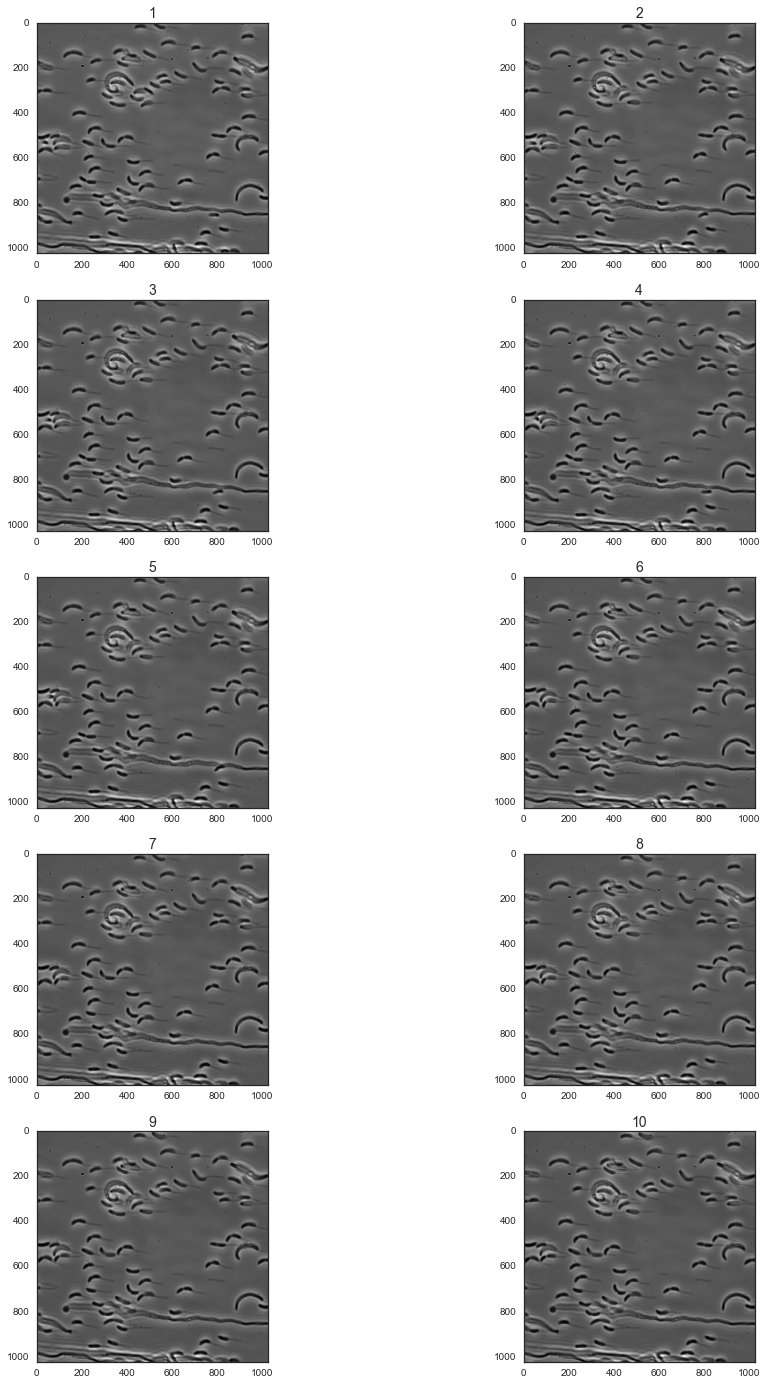

In [4]:
# Get image file names
file1 = image_dir + 'phase03000.tif'
file2 = image_dir + 'phase03001.tif'
file3 = image_dir + 'phase03002.tif'
file4 = image_dir + 'phase03003.tif'
file5 = image_dir + 'phase03004.tif'
file6 = image_dir + 'phase03005.tif'
file7 = image_dir + 'phase03006.tif'
file8 = image_dir + 'phase03007.tif'
file9 = image_dir + 'phase03008.tif'
file10 = image_dir + 'phase03009.tif'

# Load images and store in list 
im_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
ims = [skimage.io.imread(file1),
       skimage.io.imread(file2),
       skimage.io.imread(file3),
       skimage.io.imread(file4),
       skimage.io.imread(file5),
       skimage.io.imread(file6),
       skimage.io.imread(file7),
       skimage.io.imread(file8),
       skimage.io.imread(file9),
       skimage.io.imread(file10)]
# Say which images go in which subplots
im_sp = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1), (4,0), (4,1)]
# Display images
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(ims[i], cmap=plt.cm.gray)
        ax[im_sp[i]].set_title(im_names[i])

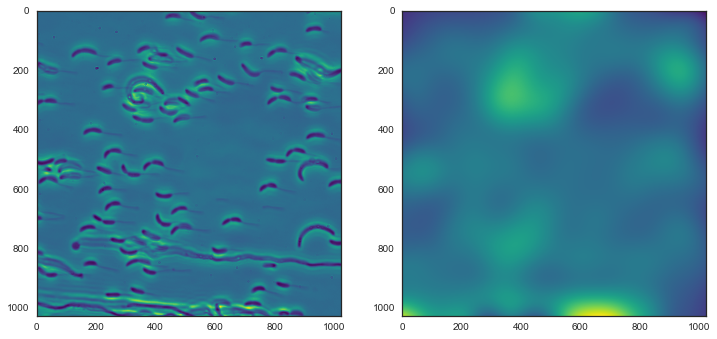

In [5]:
im_float = skimage.img_as_float(ims[0])
im_bg = skimage.filters.gaussian(im_float, 50.0)
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    ax[0].imshow(im_float, cmap=plt.cm.viridis)
    ax[1].imshow(im_bg, cmap=plt.cm.viridis)

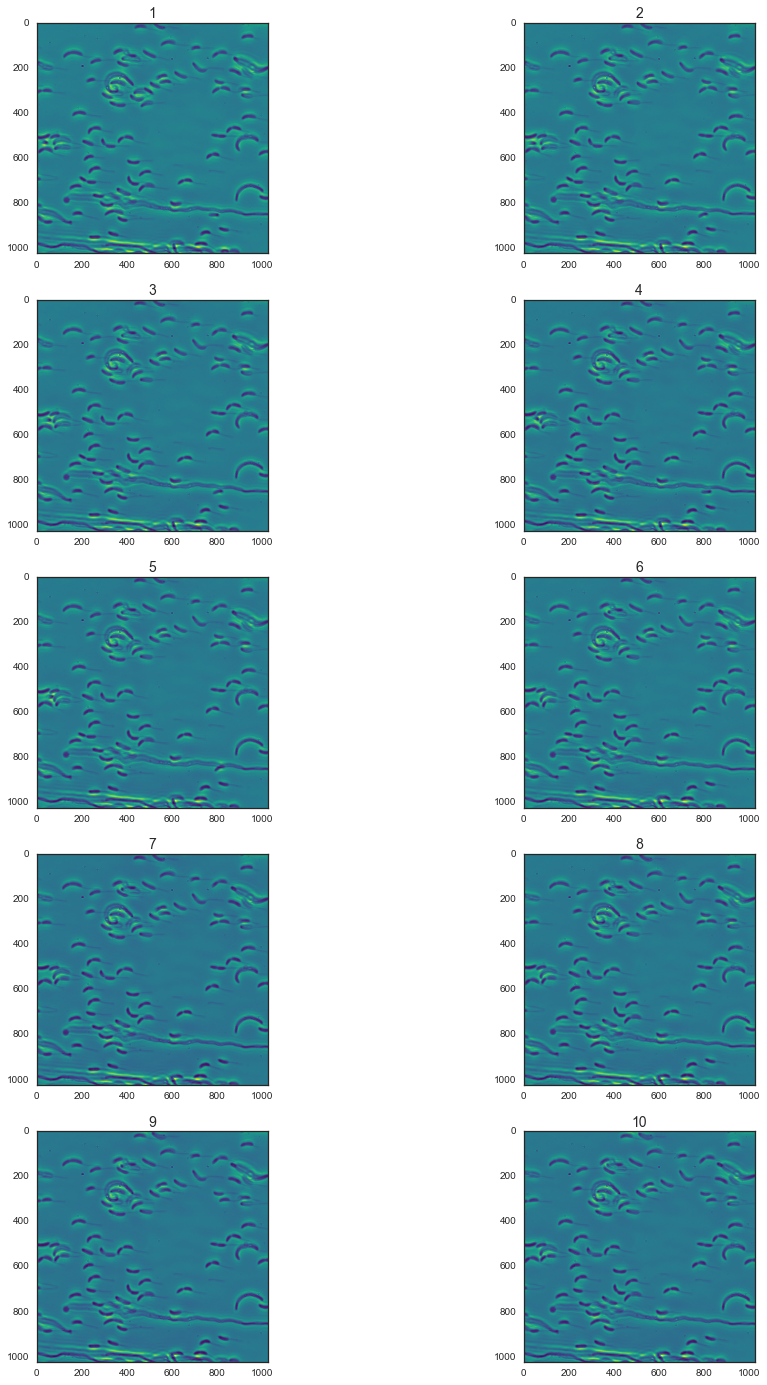

In [6]:
# Subtract background
im_no_bg = im_float - im_bg

noBG = []

for i in ims:
    im_float = skimage.img_as_float(i)
    im_bg = skimage.filters.gaussian(im_float, 50.0)
    im_no_bg = im_float - im_bg
    noBG.append(im_no_bg)

# Show image
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(noBG[i], cmap=plt.cm.viridis)
        ax[im_sp[i]].set_title(im_names[i])

In [7]:
def bebi103_thresh(im, selem, white_true=True, k_range=(0.5, 1.5), 
                   min_size=100):
    """
    Threshold image as described above.  Morphological mean filter is 
    applied using selem.
    """    
    # Determine comparison operator
    if white_true:
        compare = np.greater
        sign = -1
    else:
        compare = np.less
        sign = 1
    
    # Do the mean filter
    im_mean = skimage.filters.rank.mean(im, selem)

    # Compute number of pixels in binary image as a function of k
    k = np.linspace(k_range[0], k_range[1], 100)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = compare(im, k[i] * im_mean).sum() 

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))

    # Find index of maximal second derivative
    max_ind = np.argmax(sign * dn_pix_dk2)

    # Use this index to set k
    k_opt = k[max_ind - sign * 2]

    # Threshold with this k
    im_bw = compare(im, k_opt * im_mean)

    # Remove all the small objects
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=min_size)
   
    return im_bw, k_opt

C:\Users\andre_000\Anaconda3\lib\site-packages\skimage\filters\rank\generic.py:68: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


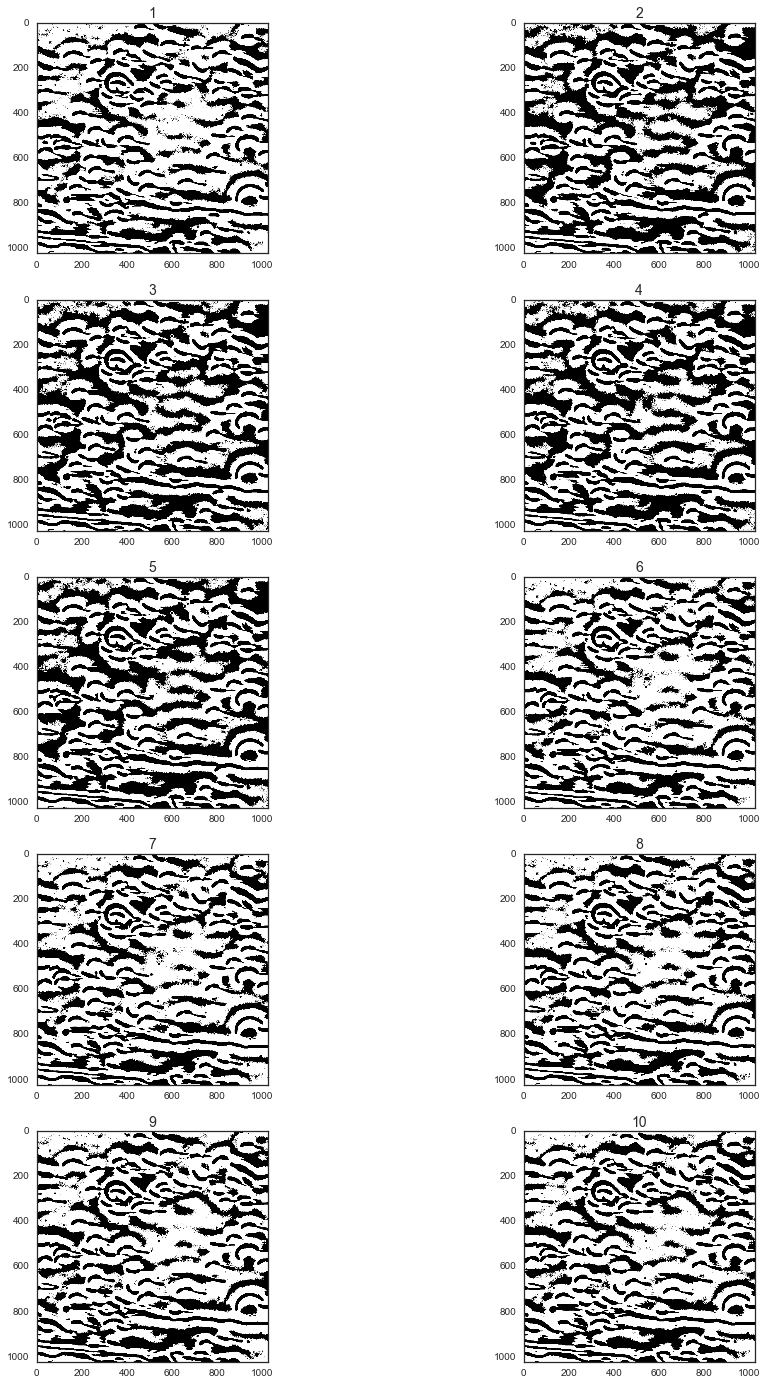

In [8]:
# Make the structuring element 50 pixel radius disk
selem = skimage.morphology.disk(50)
finalImages = []
for i in range(len(ims)):
    im_bw, k = bebi103_thresh(ims[i], selem, white_true=True, min_size=400)
    finalImages.append(im_bw)
    
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(finalImages[i], cmap=plt.cm.gray)
        ax[im_sp[i]].set_title(im_names[i])
        

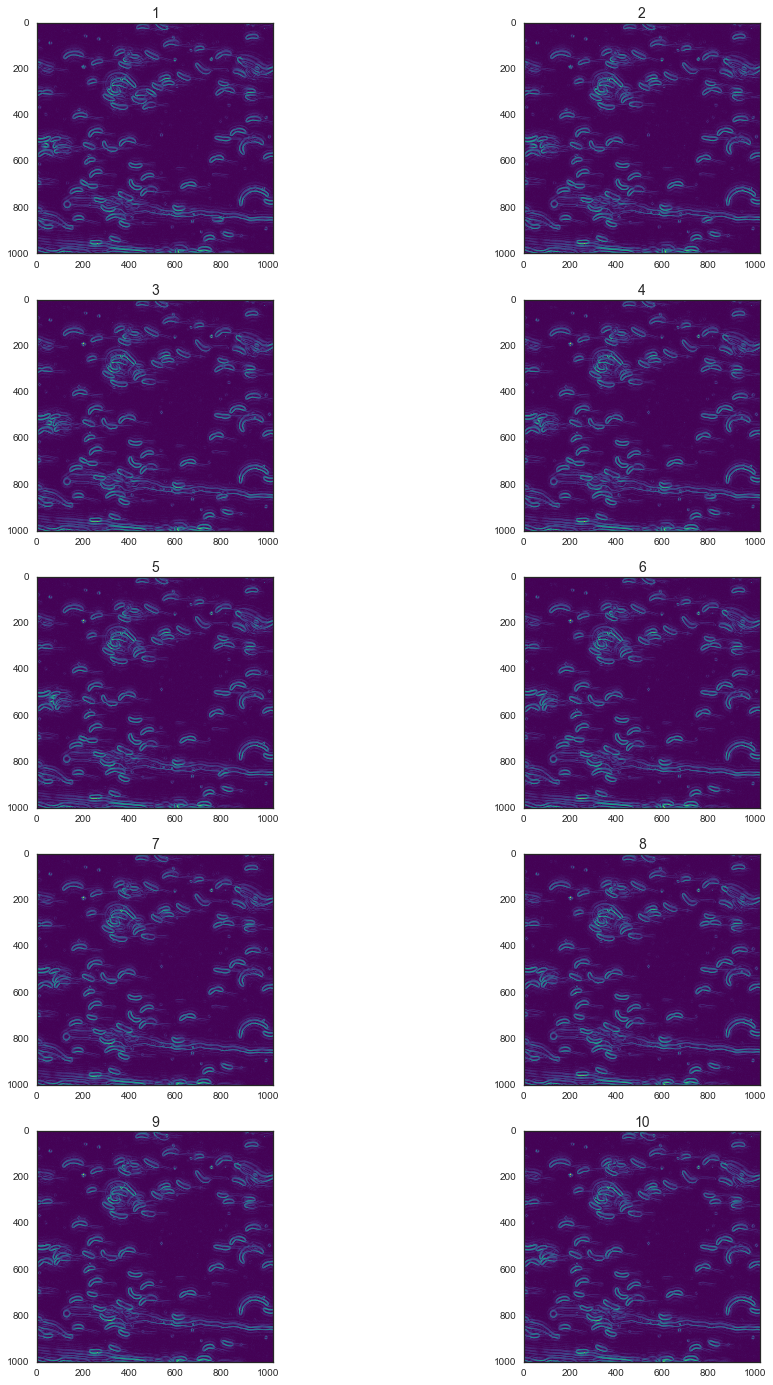

In [9]:
zoom = np.s_[0:1000, 0:1050]
moreImages = []
for i in range(len(ims)):
    im = ims[i]
    # Convert image to float
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

    # Apply the Sobel filter to find the gradient
    im_grad = skimage.filters.sobel(im_float)
    moreImages.append(im_grad)

with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(moreImages[i][zoom], cmap=plt.cm.viridis)
        ax[im_sp[i]].set_title(im_names[i])


Now, we will zoom in on specific bacteria that are "good" candidates for imaging and conversely, bacteria/ groups of bacteria that will not be good for imaging

We first start with a poor example.

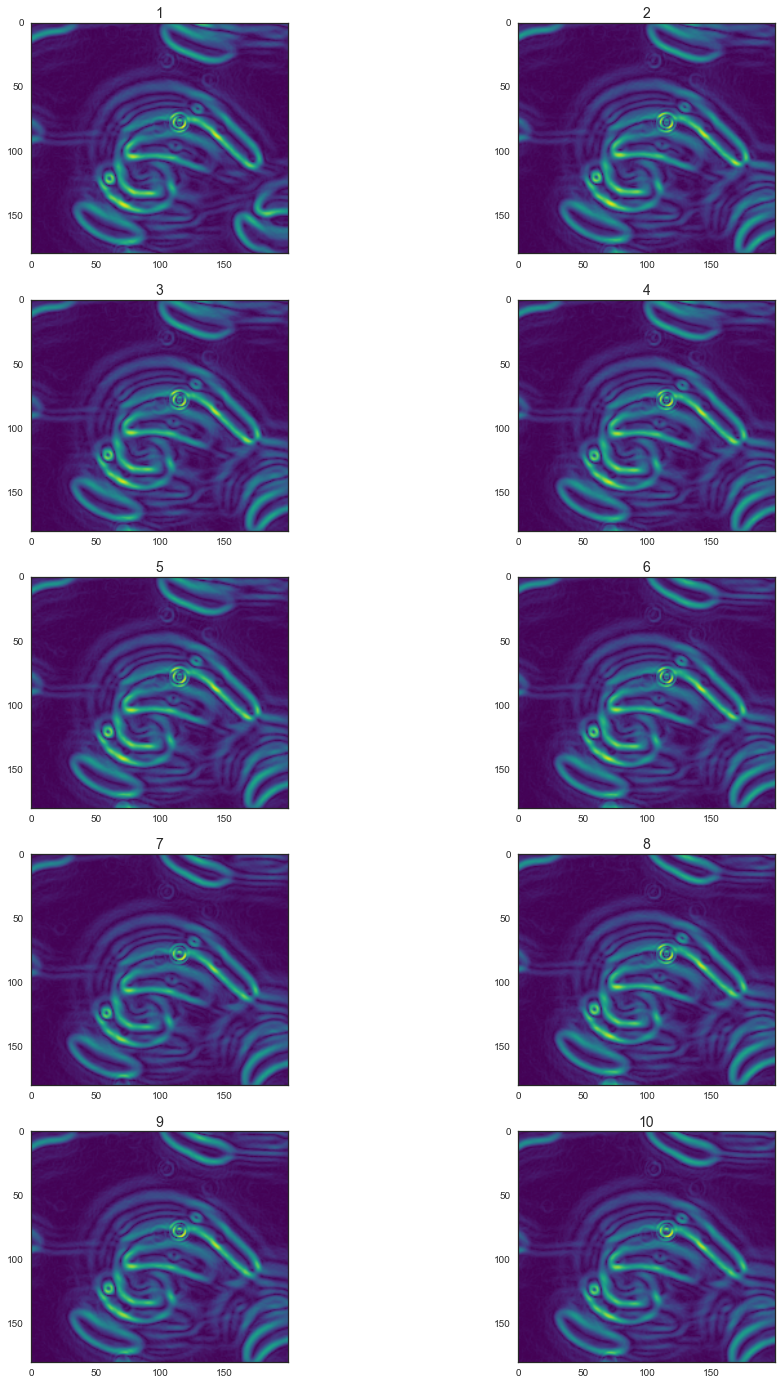

In [62]:
zoom = np.s_[170:350, 250:450]
badBacteria = []
for i in range(len(ims)):
    im = ims[i]
    # Convert image to float
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

    # Apply the Sobel filter to find the gradient
    im_grad = skimage.filters.sobel(im_float)
    badBacteria.append(im_grad)

with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(badBacteria[i][zoom], cmap=plt.cm.viridis)
        ax[im_sp[i]].set_title(im_names[i])


We see that this area of bacteria would not be the best for imaging. Even via segmentation by edge detection through sobel filtering, the bacteria still seem crowded and the false coloring almost blends in. This makes it hard to differentiate single bacteria from the rest of them, thus making it a bad candidate for long-term imaging. 

Now for a good candidate...

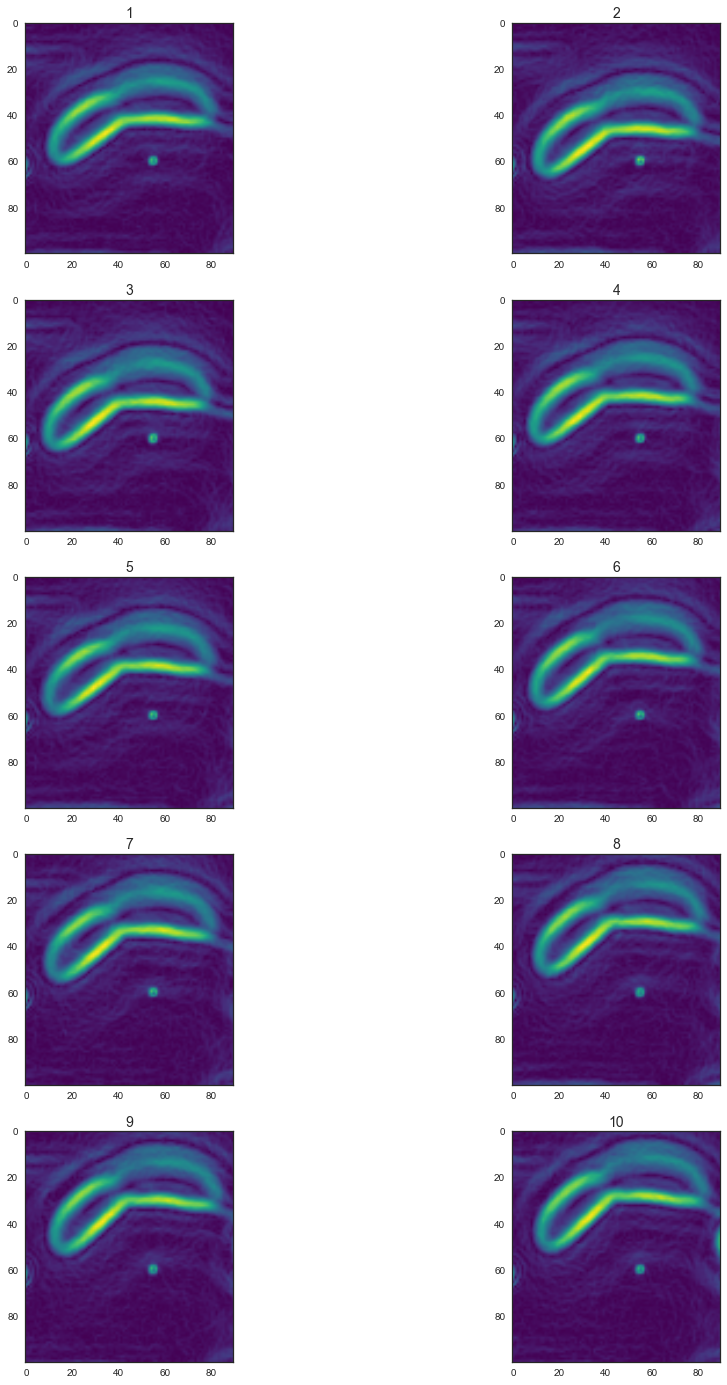

In [63]:
zoom = np.s_[100:200, 760:850]
goodBacteria = []
for i in range(len(ims)):
    im = ims[i]
    # Convert image to float
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

    # Apply the Sobel filter to find the gradient
    im_grad = skimage.filters.sobel(im_float)
    goodBacteria.append(im_grad)
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(goodBacteria[i][zoom], cmap=plt.cm.viridis)
        ax[im_sp[i]].set_title(im_names[i])

This bacteria is isolated from nearby bacteria and edge detection clearly encompasses the entire bacteria. Also, from the sequence of images, it seems that this bacteria is increasing in size, and given more timeframes, we would be able to see the actual division occur cleanly. 

Now, we will show another good candidate. In the 10 frames, we actually see clean division for this bacteria, as desired. 

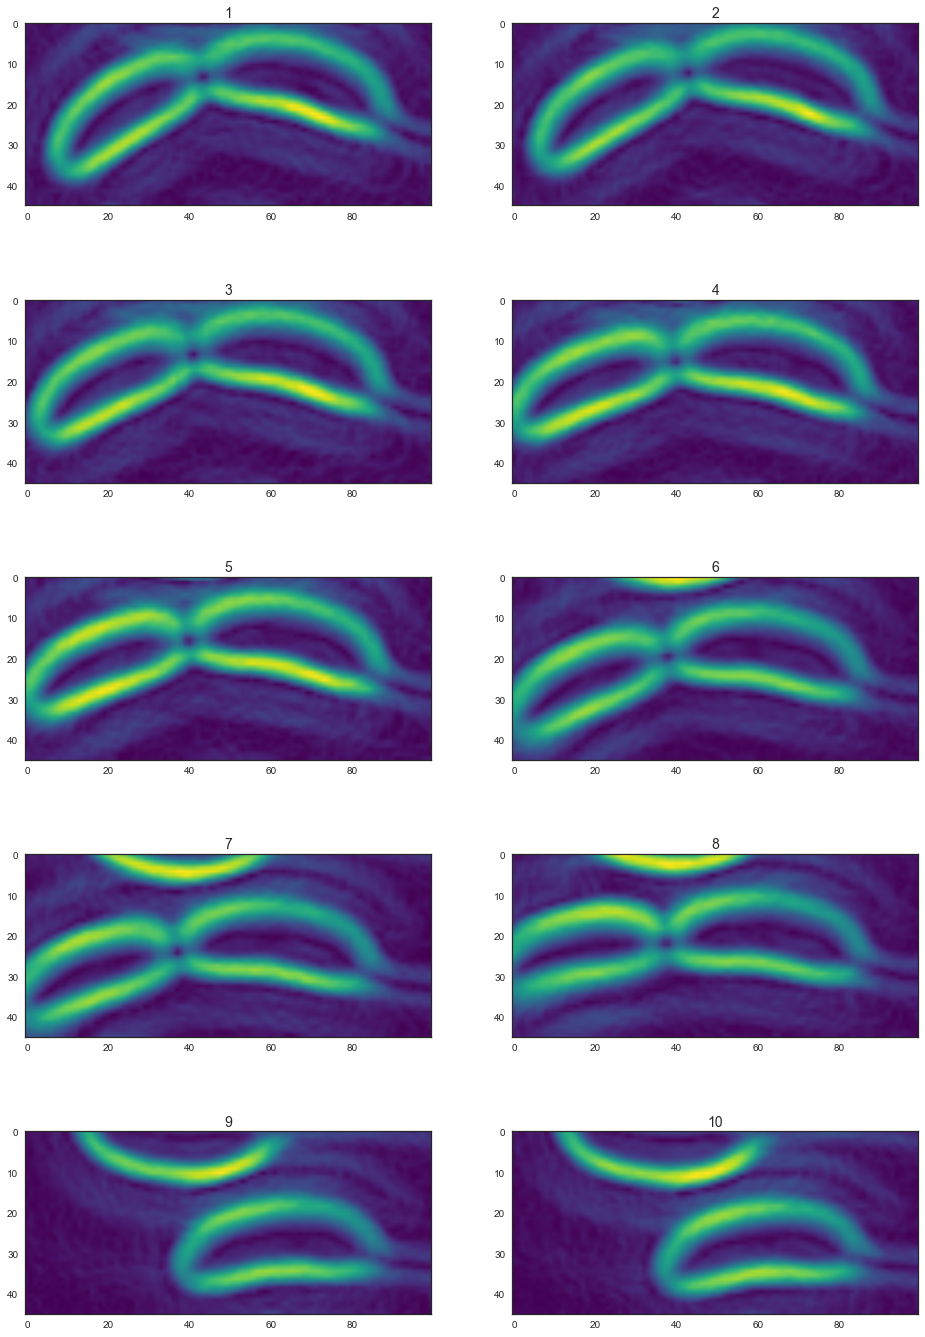

In [64]:
zoom = np.s_[280:325, 765:865]
goodBacteria1 = []
for i in range(len(ims)):
    im = ims[i]
    # Convert image to float
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

    # Apply the Sobel filter to find the gradient
    im_grad = skimage.filters.sobel(im_float)
    goodBacteria1.append(im_grad)
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(goodBacteria1[i][zoom], cmap=plt.cm.viridis)
        ax[im_sp[i]].set_title(im_names[i])

We see that from frame 8 to 9, the bacteria has divided and one of its daughter cells has washed away. Above, we have shown two examples of good bacteria for imaging and one that is not so great.

## 9.1 Part B ##

We first use edge detection to find the bacteria of interest. We will demonstrate it on the first image of bacterium_1.tif and then generalize it for the entire stack.

In [104]:
data_dir = '../data/iyer_biswas_et_al/'

# Glob string for images
im_glob = data_dir + "bacterium_1.tif"

ic = skimage.io.ImageCollection(im_glob, conserve_memory=True)

In [105]:
(ic[0])

array([[4795, 4752, 4742, ..., 4704, 4693, 4745],
       [4740, 4822, 4796, ..., 4728, 4699, 4696],
       [4775, 4778, 4779, ..., 4680, 4673, 4679],
       ..., 
       [3447, 3736, 3998, ..., 4637, 4645, 4659],
       [4127, 4445, 4757, ..., 4635, 4711, 4669],
       [4830, 5191, 5555, ..., 4709, 4657, 4681]], dtype=uint16)

In [106]:
len(ic)

1900

In [107]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]


In [108]:
fps = 1/60
t = np.arange(0, len(ic)) / fps

In [109]:
verts1 =[(27.250408965270861, 27.041011909137055), (25.219684861703936, 75.524549881797498), (123.96364439764587, 77.555273985364423), (122.18676080702481, 28.817895499758123)]

<div class="alert alert-info">
You have to be careful when drawing your ROI in this case. What assumptions are you making by restricting the size of the image? You are essentially drawing an 'area abound' where you will never be able to measure areas past a given size because they would extend beyond the boundaries of your ROI, as  you have many (many) images in this stack, it is not really safe to say what the largest daughter cell size is. This is part of the reason why the images are so rectangular in the first place.
</div> 

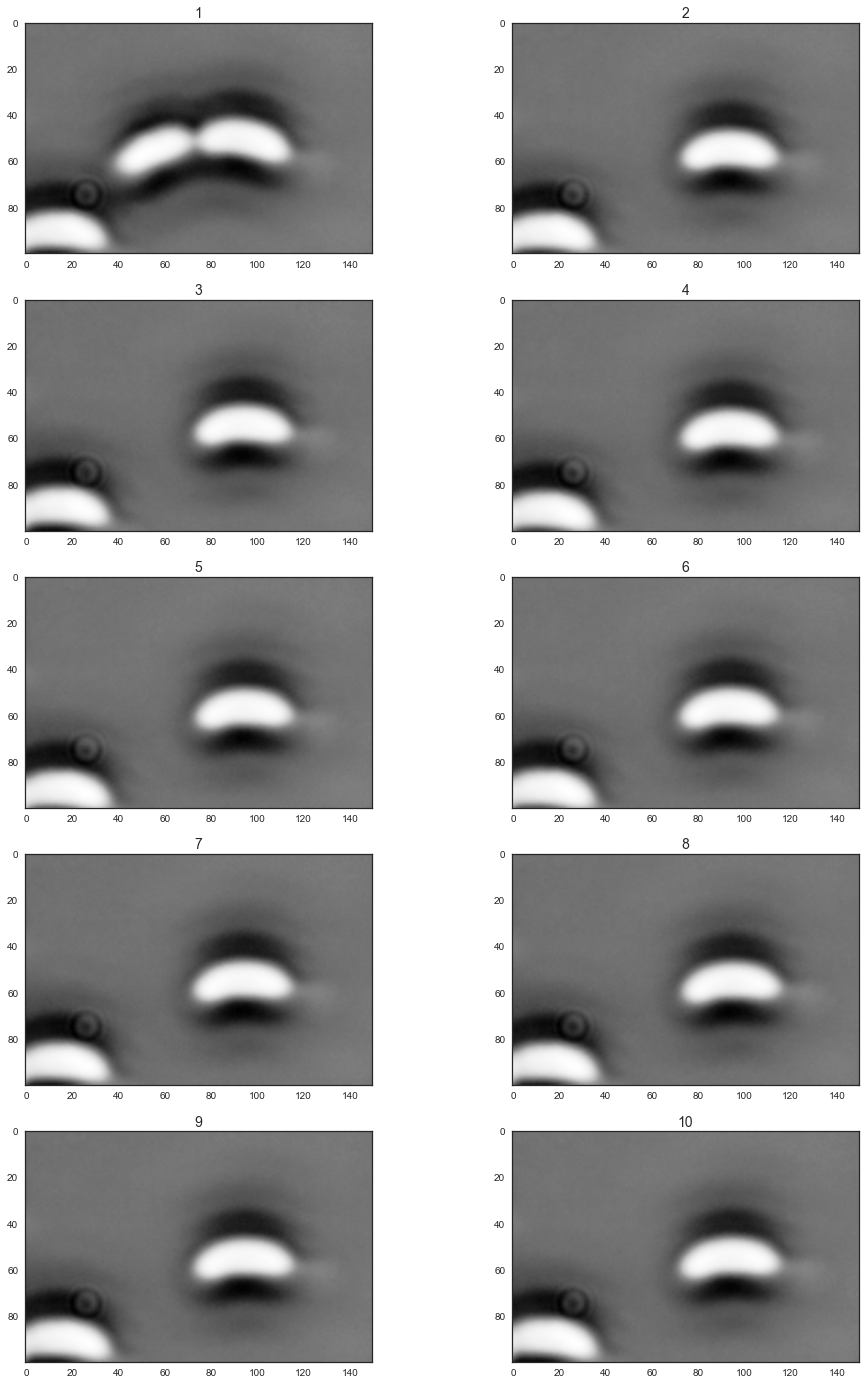

In [110]:
first10 = []
for i in range(10):
    im = ic[i] / ic[i].max()
    first10.append(im)
with sns.axes_style('white'):
    fig, ax = plt.subplots(5, 2, figsize=(16, 24))
    for i in range(10):
        ax[im_sp[i]].imshow(first10[i])
        ax[im_sp[i]].set_title(im_names[i])

In [111]:
def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

In [112]:
def getWhitePixels(image):
    '''
    This function takes a black and white image and returns the number of pixels which are colored white.
    '''
    numWhite = 0
    for i in im_bw:
        for j in i:
            if (j):
                numWhite += 1
    return numWhite

In [113]:
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)

In [114]:
# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)


In [115]:
im = ic[0]
im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
im_edge = skimage.feature.canny(im_float, 1.4)
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

In [116]:
# Close the edge image
selem = skimage.morphology.disk(2)
im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

# Fill these holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)

In [117]:
# 3x3 square structuring element
selem = skimage.morphology.square(3)
    
# Do max filter and min filter
im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

# Image of zero-crossings
im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))

In [118]:
im_edge = zero_crossing_filter(im_LoG, 0.001)

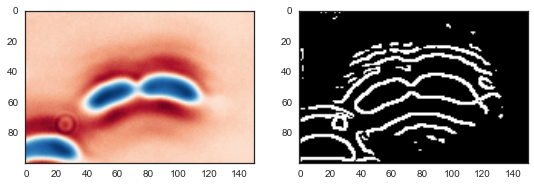

In [119]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float, cmap=plt.cm.RdBu_r)
    ax[1].imshow(im_edge, cmap=plt.cm.gray)

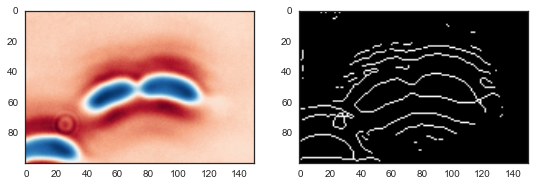

In [120]:
im_edge = skimage.morphology.skeletonize(im_edge)
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(9,5))
    ax[0].imshow(im_float, cmap=plt.cm.RdBu_r)
    ax[1].imshow(im_edge, cmap=plt.cm.gray)

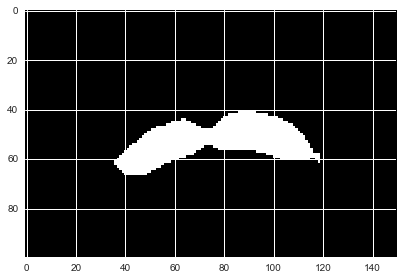

In [121]:
# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)
skimage.io.imshow(im_bw)

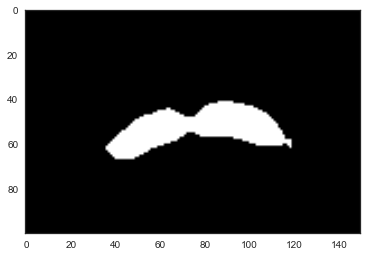

In [122]:
im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

In [123]:
getWhitePixels(im_bw)

1084

We see that for the first frame of bacterium1, we have 1084 white pixels. Let's repeat this for the second frame and see what we get.

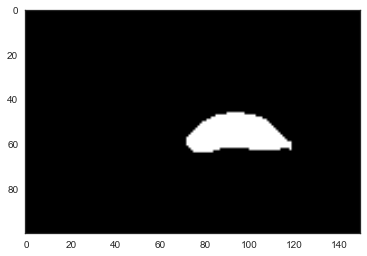

In [124]:
im = ic[1]
im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
im_edge = skimage.feature.canny(im_float, 1.4)
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
# Close the edge image
selem = skimage.morphology.disk(2)
im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

# Fill these holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
# 3x3 square structuring element
selem = skimage.morphology.square(3)
    
# Do max filter and min filter
im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

# Image of zero-crossings
im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
    | ((im_LoG <= 0) & (im_LoG_max > 0))
im_edge = zero_crossing_filter(im_LoG, 0.001)
im_edge = skimage.morphology.skeletonize(im_edge)
# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

In [125]:
getWhitePixels(im_bw)

594

For the second frame (after what we can assume to be division because the bacterium has shrunk), we get 594 white pixels, about half of the number of white pixels in the first frame which makes sense because the daughter cell has washed away. Thus, we have come to a reasonable method of quantifying division and area.

Number of individual bacteria =  1


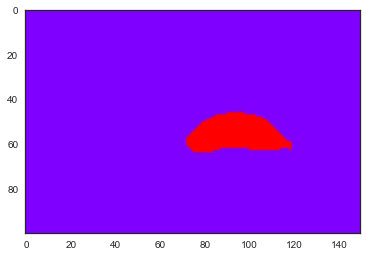

In [126]:
# Label binary image; backward kwarg says value in im_bw to consider backgr.
im_labeled, n_labels = skimage.measure.label(
                            im_bw, background=0, return_num=True)

# See result (one of the few times it's ok to use rainbow colormap!)
with sns.axes_style('white'):
    plt.imshow(im_labeled, cmap=plt.cm.rainbow)

# Show number of bacteria
print('Number of individual bacteria = ', n_labels)

We have successfully edged off the bacteria from the background and isolated it from its surroundings. We will repeat this process for all images of the stack now. 

In [127]:
pixels = []
for i in ic:
    im = i
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    pixels.append(getWhitePixels(im_bw))

In [212]:
print(pixels)

[1084, 594, 601, 607, 617, 613, 613, 619, 628, 638, 641, 637, 636, 637, 649, 650, 649, 660, 658, 659, 663, 670, 670, 682, 677, 688, 689, 688, 695, 707, 720, 714, 709, 354, 540, 727, 735, 743, 894, 149, 176, 875, 863, 879, 877, 785, 892, 109, 801, 908, 104, 911, 103, 103, 934, 934, 941, 953, 856, 859, 964, 995, 980, 987, 997, 1000, 998, 128, 1005, 1002, 911, 919, 928, 1027, 942, 1056, 949, 1073, 1019, 966, 1078, 982, 991, 999, 1008, 1007, 1015, 1005, 1030, 1029, 1035, 1052, 1058, 1054, 527, 799, 1072, 1185, 1131, 612, 611, 631, 621, 626, 633, 316, 478, 640, 645, 653, 654, 656, 662, 669, 677, 677, 338, 514, 691, 698, 685, 699, 702, 710, 713, 717, 721, 720, 781, 842, 840, 100, 102, 51, 465, 880, 768, 757, 920, 1084, 776, 890, 102, 901, 907, 100, 805, 458, 112, 106, 925, 829, 938, 841, 850, 859, 852, 861, 866, 868, 882, 935, 988, 901, 1003, 903, 899, 918, 920, 924, 928, 935, 928, 938, 950, 957, 965, 974, 960, 982, 986, 982, 1003, 1013, 1012, 1026, 1028, 1035, 1042, 1046, 1055, 1063, 1066, 

In [28]:
# The above calculation takes forever, so for ease, after running it one time, I saved the values. For the interest of time,
# the values are below:
pixels = [1084, 594, 601, 607, 617, 613, 613, 619, 628, 638, 641, 637, 636, 637, 649, 650, 649, 660, 658, 659, 663, 670, 670, 682, 677, 688, 689, 688, 695, 707, 720, 714, 709, 354, 540, 727, 735, 743, 894, 149, 176, 875, 863, 879, 877, 785, 892, 109, 801, 908, 104, 911, 103, 103, 934, 934, 941, 953, 856, 859, 964, 995, 980, 987, 997, 1000, 998, 128, 1005, 1002, 911, 919, 928, 1027, 942, 1056, 949, 1073, 1019, 966, 1078, 982, 991, 999, 1008, 1007, 1015, 1005, 1030, 1029, 1035, 1052, 1058, 1054, 527, 799, 1072, 1185, 1131, 612, 611, 631, 621, 626, 633, 316, 478, 640, 645, 653, 654, 656, 662, 669, 677, 677, 338, 514, 691, 698, 685, 699, 702, 710, 713, 717, 721, 720, 781, 842, 840, 100, 102, 51, 465, 880, 768, 757, 920, 1084, 776, 890, 102, 901, 907, 100, 805, 458, 112, 106, 925, 829, 938, 841, 850, 859, 852, 861, 866, 868, 882, 935, 988, 901, 1003, 903, 899, 918, 920, 924, 928, 935, 928, 938, 950, 957, 965, 974, 960, 982, 986, 982, 1003, 1013, 1012, 1026, 1028, 1035, 1042, 1046, 1055, 1063, 1066, 1071, 1079, 1087, 619, 610, 621, 624, 631, 642, 645, 649, 651, 657, 656, 659, 659, 329, 505, 682, 341, 518, 696, 699, 703, 706, 709, 704, 719, 711, 720, 722, 163, 730, 743, 750, 375, 187, 472, 757, 762, 768, 783, 788, 890, 891, 787, 798, 805, 805, 813, 813, 822, 832, 829, 828, 845, 848, 850, 857, 862, 872, 866, 882, 885, 891, 893, 894, 908, 913, 911, 929, 935, 1039, 938, 945, 957, 961, 975, 978, 982, 984, 997, 1002, 1004, 1011, 1012, 1027, 1032, 1028, 1048, 1048, 1055, 1083, 1075, 1083, 1091, 1094, 1096, 1121, 1113, 1120, 1119, 1134, 1138, 1166, 1158, 610, 634, 623, 625, 632, 632, 634, 636, 643, 646, 654, 663, 660, 658, 665, 681, 681, 681, 689, 699, 695, 706, 717, 718, 719, 723, 722, 748, 730, 740, 749, 748, 752, 756, 757, 768, 775, 778, 789, 789, 786, 789, 795, 802, 799, 815, 819, 827, 831, 838, 839, 849, 858, 849, 863, 867, 872, 869, 880, 896, 901, 902, 907, 919, 914, 918, 928, 939, 930, 941, 947, 959, 959, 960, 968, 979, 984, 984, 1003, 1004, 1014, 1015, 1033, 1037, 1037, 1049, 1048, 1069, 1070, 1076, 1075, 1081, 1089, 1088, 1113, 1102, 1103, 664, 662, 669, 676, 674, 672, 678, 689, 690, 692, 697, 348, 525, 702, 709, 717, 735, 735, 735, 738, 748, 744, 747, 373, 186, 146, 107, 150, 75, 37, 419, 802, 907, 863, 820, 925, 462, 651, 841, 843, 845, 847, 860, 862, 872, 882, 876, 884, 893, 900, 907, 906, 915, 922, 929, 936, 934, 951, 954, 955, 956, 966, 969, 965, 980, 983, 994, 997, 1015, 1021, 1031, 1039, 1046, 1056, 1045, 1061, 1070, 1087, 1081, 1079, 1107, 1104, 1108, 1118, 1137, 1143, 1144, 1147, 1161, 1167, 1180, 1187, 1186, 1198, 1201, 1224, 1204, 1215, 1269, 1256, 1243, 1249, 1224, 1199, 977, 755, 753, 751, 753, 376, 188, 94, 436, 779, 791, 395, 197, 499, 801, 400, 200, 509, 818, 409, 682, 955, 103, 146, 73, 465, 858, 869, 434, 217, 108, 54, 27, 13, 462, 911, 911, 919, 922, 461, 230, 115, 535, 956, 957, 967, 980, 994, 1003, 1012, 506, 765, 1025, 1031, 1172, 1036, 1038, 1060, 1065, 1061, 1069, 1082, 1083, 1092, 1107, 1114, 1113, 1111, 1129, 1135, 1155, 1157, 1158, 1159, 1176, 1170, 1185, 1212, 1208, 1208, 1223, 1226, 1240, 1245, 1264, 1281, 1302, 1297, 1313, 1297, 1308, 654, 327, 831, 1335, 1036, 738, 369, 184, 92, 429, 767, 773, 773, 774, 387, 193, 96, 48, 24, 12, 6, 419, 833, 831, 415, 207, 157, 107, 1091, 108, 961, 915, 869, 881, 883, 904, 452, 681, 910, 913, 918, 924, 105, 945, 958, 965, 974, 983, 988, 991, 995, 1008, 1006, 1005, 1013, 1008, 1032, 1035, 1037, 1039, 1042, 1078, 1049, 1087, 1088, 1104, 1108, 1109, 1114, 1124, 1119, 1116, 1151, 1145, 1153, 1155, 1178, 1181, 1196, 1195, 1208, 1220, 1230, 1245, 1260, 1265, 1280, 1285, 1288, 1280, 1269, 634, 961, 1289, 644, 322, 161, 80, 40, 20, 10, 372, 734, 367, 183, 464, 746, 373, 186, 93, 46, 23, 11, 404, 797, 398, 199, 99, 450, 801, 451, 101, 101, 838, 841, 845, 422, 688, 954, 535, 117, 499, 882, 504, 127, 1002, 955, 909, 912, 916, 931, 934, 939, 469, 234, 117, 58, 512, 966, 980, 994, 996, 995, 995, 1002, 1010, 1019, 509, 772, 1035, 1039, 1044, 1056, 528, 806, 1085, 1090, 1095, 1106, 1109, 1112, 556, 850, 1144, 1155, 1160, 1173, 1186, 1199, 1204, 1209, 1196, 598, 299, 149, 74, 37, 18, 9, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 146, 150, 154, 143, 181, 224, 240, 106, 113, 114, 100, 119, 125, 113, 131, 113, 119, 127, 112, 122, 117, 108, 100, 103, 106, 113, 118, 59, 81, 103, 102, 101, 100, 100, 102, 104, 119, 100, 117, 119, 108, 103, 122, 115, 109, 992, 102, 102, 132, 144, 650, 1156, 632, 108, 1044, 1047, 1055, 1063, 531, 265, 187, 110, 115, 1092, 1117, 105, 1128, 104, 1239, 1153, 1167, 1175, 1280, 1184, 1202, 1224, 1224, 612, 306, 153, 76, 38, 19, 9, 4, 345, 686, 701, 716, 358, 179, 89, 44, 87, 131, 133, 114, 130, 140, 133, 139, 145, 138, 120, 143, 139, 110, 138, 111, 136, 129, 125, 100, 105, 113, 122, 126, 130, 65, 95, 125, 126, 118, 120, 124, 129, 135, 125, 1013, 986, 556, 127, 1025, 128, 923, 1053, 1042, 1081, 108, 536, 964, 963, 978, 1086, 975, 992, 993, 1007, 1115, 1014, 1013, 1152, 1035, 1162, 1157, 1168, 1541, 1178, 1205, 1218, 1075, 1089, 1225, 1102, 1215, 1224, 1122, 1254, 1244, 1151, 1159, 1157, 1163, 1235, 617, 308, 154, 77, 90, 103, 103, 104, 115, 107, 106, 53, 26, 70, 115, 133, 151, 135, 135, 136, 116, 136, 103, 107, 107, 124, 120, 106, 907, 515, 124, 107, 917, 110, 114, 104, 954, 851, 100, 100, 109, 129, 982, 135, 104, 1002, 1027, 136, 1047, 1042, 1031, 1062, 1065, 1069, 1072, 1072, 1083, 1082, 1101, 1114, 1090, 1096, 1105, 138, 1138, 1152, 1163, 1150, 1167, 1168, 1195, 1205, 1161, 1071, 1205, 1221, 1196, 1233, 1211, 1226, 1223, 1105, 1228, 1112, 1254, 1254, 1248, 1247, 1251, 1268, 1282, 1180, 1249, 1240, 1248, 1243, 1294, 1431, 827, 125, 122, 61, 30, 377, 725, 737, 726, 730, 752, 436, 121, 60, 94, 129, 901, 138, 785, 924, 515, 106, 979, 138, 947, 914, 101, 926, 933, 951, 969, 984, 993, 967, 865, 131, 992, 986, 990, 1032, 1032, 1026, 1031, 1023, 1061, 1034, 1043, 1055, 1059, 1061, 1058, 1115, 1078, 1113, 1129, 1108, 1104, 1113, 1149, 1113, 1161, 1154, 1160, 1157, 1149, 1189, 1170, 1215, 1208, 1196, 1204, 1196, 1205, 1093, 1200, 1103, 1129, 1126, 1131, 1141, 1155, 1161, 1167, 1170, 1186, 1188, 1195, 1315, 1222, 1228, 1230, 1259, 1311, 804, 714, 357, 527, 698, 710, 716, 722, 1380, 715, 733, 740, 737, 101, 859, 754, 881, 857, 171, 116, 872, 904, 114, 139, 966, 916, 906, 944, 919, 951, 954, 975, 969, 967, 975, 1016, 974, 998, 1003, 116, 996, 985, 1031, 1006, 1000, 1049, 1064, 1034, 1065, 1033, 1076, 1068, 1094, 1100, 1118, 1145, 1105, 1110, 1143, 1163, 1172, 1121, 1137, 1161, 1121, 1133, 1152, 1162, 1135, 1163, 1171, 1167, 1168, 1189, 1190, 1192, 1200, 1207, 1233, 1121, 1235, 1250, 1258, 1242, 1259, 1212, 1211, 1224, 1230, 1187, 1208, 1216, 1161, 1153, 1149, 1161, 1153, 1168, 1180, 1170, 1191, 1271, 936, 1111, 1286, 1292, 155, 851, 838, 838, 841, 853, 106, 892, 135, 955, 897, 112, 149, 140, 917, 111, 118, 910, 112, 913, 922, 943, 957, 139, 969, 984, 972, 978, 997, 160, 1040, 235, 1065, 1022, 1022, 1039, 1065, 1041, 1052, 1074, 1073, 1081, 1096, 1073, 1089, 1088, 1061, 1102, 1115, 1126, 1124, 1113, 1128, 1125, 1134, 1156, 1147, 1151, 1134, 1167, 1132, 1141, 1148, 1148, 1157, 1161, 1177, 1155, 1069, 1205, 1207, 1208, 1115, 1134, 1134, 1138, 1251, 1264, 1140, 1212, 1215, 1177, 1169, 445, 222, 478, 734, 367, 557, 747, 136, 109, 111, 867, 108, 1294, 898, 116, 115, 910, 936, 156, 168, 916, 978, 200, 979, 971, 1022, 1039, 1037, 1020, 1001, 1033, 1067, 1035, 156, 1034, 1019, 176, 1062, 1094, 1022, 137, 1031, 1070, 1074, 1110, 1072, 1071, 1160, 1118, 1115, 1125, 1115, 1136, 1167, 1129, 1181, 1151, 1164, 1176, 1169, 1144, 1164, 1154, 1177, 1188, 1181, 1198, 1187, 1200, 1231, 1362, 1229, 1239, 1146, 1247, 1260, 1257, 1171, 1330, 1300, 1323, 1206, 1213, 1237, 1245, 622, 378, 135, 142, 149, 816, 842, 136, 166, 133, 801, 135, 153, 837, 472, 107, 105, 103, 102, 105, 127, 111, 116, 878, 133, 124, 904, 131, 128, 919, 219, 1033, 210, 173, 1000, 216, 971, 153, 1006, 1008, 167, 1016, 1041, 1023, 865, 989, 1044, 1048, 1017, 139, 125, 1031, 160, 1031, 1060, 1043, 1083, 1087, 1106, 1052, 1068, 1068, 1102, 1081, 1128, 1132, 1114, 1103, 1100, 1107, 1127, 1108, 1134, 1165, 1134, 1185, 1177, 1050, 1178, 1168, 1184, 1197, 1204, 1199, 1241, 1237, 1245, 1164, 1181, 1272, 170, 143, 155, 154, 159, 135, 124, 173, 136, 144, 126, 115, 148, 203, 164, 137, 117, 866, 128, 120, 142, 122, 111, 177, 165, 912, 174, 176, 169, 169, 212, 179, 201, 189, 177, 165, 154, 191, 163, 163, 163, 214, 201, 223, 190, 126, 178, 165, 208, 216, 1042, 205, 151, 158, 166, 117, 121, 151, 162, 120, 130, 1056, 1142, 111, 1076, 119, 1084, 1122, 130, 1097, 120, 145, 1116, 1131, 1141, 1155, 120, 1145, 136, 121, 1159, 119, 1169, 1183, 1192, 120, 116, 1219, 1217, 608, 924, 1240, 1232, 1254, 1254, 627, 313, 224, 135, 136, 124, 118, 115, 124, 115, 117, 58, 342, 627, 115, 135, 148, 172, 148, 207, 176, 133, 197, 148, 156, 193, 161, 126, 156, 123, 163, 102, 105, 103, 102, 146, 174, 194, 191, 148, 199, 204, 198, 195, 183, 201, 193, 170, 127, 154, 186, 197, 184, 141, 186, 185, 201, 171, 198, 153, 1141, 1136, 194, 1132, 149, 181, 177, 1124, 165, 152, 128, 137, 122, 1161, 1146, 173, 101, 1170, 129, 123, 1170, 125, 164, 1227, 1186, 160, 1102, 1110, 1119, 1127, 1136, 121, 113, 102, 51, 25, 12, 82, 152, 141, 182, 197, 172, 157, 170, 179, 151, 137, 154, 184, 175, 171, 154, 172, 151, 152, 169, 145, 135, 107, 127, 168, 155, 165, 182, 200, 162, 145, 201, 196, 169, 149, 139, 186, 161, 201, 252, 201, 251, 223, 172, 203, 180, 199, 226, 192, 168, 220, 190, 224, 206, 190, 153, 152, 200, 103, 190, 144, 108, 117, 126, 139, 138, 120, 1171, 132, 158, 197, 140, 1141, 1149, 173, 140, 165, 1141, 1172, 636, 100, 118, 140, 1158, 1161, 1209, 1224, 1240, 706, 173, 1268, 142, 1262, 137, 145, 154, 140, 1268, 1318, 123, 61, 92, 123, 139, 162, 156, 176, 157, 166, 137, 170, 156, 183, 130, 164, 156, 180, 184, 159, 187, 234, 130, 220, 229, 238, 237, 136, 244, 191, 168, 219, 184, 251, 162, 198, 235, 205, 245, 190, 196, 194, 199, 193, 201, 192, 196, 202, 196, 199, 108, 200, 101, 102, 100, 129, 128, 200, 124, 189, 128, 116, 101, 154, 105, 126, 111, 111, 111, 101, 101, 113, 126, 113, 125, 124, 119, 126, 113, 101, 171, 138, 133, 104, 131]

In [31]:
len(pixels)

1900

As expected, we have 1900 elements of the pixels array which is equal to number of images in the bacterium1 .tif stack.

Now, we repeat this (getting number of white pixels in b/w image), but for bacterium2. 

In [33]:
data_dir = '../data/iyer_biswas_et_al/'

# Glob string for images
im_glob = data_dir + "bacterium_2.tif"

ic1 = skimage.io.ImageCollection(im_glob, conserve_memory=True)
ic1[0]

array([[4728, 4658, 4724, ..., 4756, 4727, 4495],
       [4687, 4752, 4722, ..., 4731, 4686, 4477],
       [4693, 4698, 4695, ..., 4692, 4672, 4433],
       ..., 
       [4912, 4847, 4890, ..., 4607, 4572, 4352],
       [4928, 4887, 4919, ..., 4575, 4505, 4356],
       [4925, 4871, 4877, ..., 4628, 4519, 4342]], dtype=uint16)

In [ ]:
pixels1 = []
for i in ic1:
    im = i
    im_float = (im.astype(float) - im.min()) / (im.max() - im.min())
    im_edge = skimage.feature.canny(im_float, 1.4)
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)
    # Close the edge image
    selem = skimage.morphology.disk(2)
    im_edge_closed = skimage.morphology.binary_closing(im_edge, selem)

    # Fill these holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge_closed)
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)
    # 3x3 square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, footprint=selem)
    im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, footprint=selem)

    # Image of zero-crossings
    im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
        | ((im_LoG <= 0) & (im_LoG_max > 0))
    im_edge = zero_crossing_filter(im_LoG, 0.001)
    im_edge = skimage.morphology.skeletonize(im_edge)
    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=100)

    im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)
    pixels1.append(getWhitePixels(im_bw))


In [37]:
print(pixels1)

[1143, 625, 100, 100, 101, 101, 101, 50, 25, 12, 6, 359, 712, 714, 717, 107, 53, 26, 386, 746, 106, 862, 865, 112, 777, 113, 989, 1434, 848, 474, 100, 142, 102, 915, 132, 821, 117, 954, 106, 106, 135, 953, 995, 133, 978, 1020, 997, 1033, 112, 1019, 1017, 120, 1056, 125, 1036, 586, 136, 1054, 1077, 124, 107, 1069, 109, 974, 979, 1111, 996, 1003, 1011, 1014, 1018, 1059, 1100, 1107, 1110, 1113, 1117, 1124, 562, 852, 1143, 1151, 1160, 1157, 1155, 577, 853, 1129, 1133, 1137, 1196, 1256, 1295, 1142, 547, 1330, 630, 814, 658, 1326, 837, 231, 876, 738, 745, 877, 744, 749, 105, 873, 873, 128, 926, 795, 778, 800, 141, 940, 939, 944, 949, 155, 131, 139, 974, 1143, 101, 841, 118, 145, 977, 977, 982, 987, 875, 1013, 1007, 137, 591, 1045, 101, 924, 1056, 932, 987, 1043, 1066, 1089, 959, 964, 969, 971, 983, 991, 495, 748, 1001, 1005, 1009, 504, 772, 1040, 1044, 1049, 524, 262, 131, 65, 32, 594, 1156, 1163, 581, 290, 740, 1191, 1140, 1141, 570, 917, 1264, 1283, 1283, 102, 1286, 1193, 1321, 1200, 1355,

In [35]:
# The above calculation takes > 4 hours so instead of having to wait for it to run everytime, I saved the values:
# These are number of white pixels per frame for the second bacteria

pixels1 = [1143, 625, 100, 100, 101, 101, 101, 50, 25, 12, 6, 359, 712, 714, 717, 107, 53, 26, 386, 746, 106, 862, 865, 112, 777, 113, 989, 1434, 848, 474, 100, 142, 102, 915, 132, 821, 117, 954, 106, 106, 135, 953, 995, 133, 978, 1020, 997, 1033, 112, 1019, 1017, 120, 1056, 125, 1036, 586, 136, 1054, 1077, 124, 107, 1069, 109, 974, 979, 1111, 996, 1003, 1011, 1014, 1018, 1059, 1100, 1107, 1110, 1113, 1117, 1124, 562, 852, 1143, 1151, 1160, 1157, 1155, 577, 853, 1129, 1133, 1137, 1196, 1256, 1295, 1142, 547, 1330, 630, 814, 658, 1326, 837, 231, 876, 738, 745, 877, 744, 749, 105, 873, 873, 128, 926, 795, 778, 800, 141, 940, 939, 944, 949, 155, 131, 139, 974, 1143, 101, 841, 118, 145, 977, 977, 982, 987, 875, 1013, 1007, 137, 591, 1045, 101, 924, 1056, 932, 987, 1043, 1066, 1089, 959, 964, 969, 971, 983, 991, 495, 748, 1001, 1005, 1009, 504, 772, 1040, 1044, 1049, 524, 262, 131, 65, 32, 594, 1156, 1163, 581, 290, 740, 1191, 1140, 1141, 570, 917, 1264, 1283, 1283, 102, 1286, 1193, 1321, 1200, 1355, 1418, 149, 104, 1274, 1145, 884, 890, 903, 126, 196, 267, 526, 786, 860, 935, 937, 926, 123, 938, 469, 287, 105, 943, 948, 528, 109, 54, 507, 961, 968, 976, 114, 988, 494, 247, 123, 61, 30, 469, 909, 454, 227, 113, 56, 28, 14, 7, 3, 1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 380, 400, 420, 439, 458, 478, 498, 517, 536, 556, 576, 595, 1191, 646, 102, 51, 629, 1208, 1229, 614, 307, 153, 76, 38, 19, 9, 662, 1315, 657, 328, 164, 82, 41, 20, 10, 5, 668, 1331, 1493, 598, 595, 844, 713, 583, 775, 762, 823, 885, 442, 221, 110, 55, 27, 13, 64, 115, 57, 28, 14, 7, 3, 1, 3, 5, 7, 9, 11, 13, 15, 18, 20, 22, 25, 28, 30, 32, 35, 38, 40, 42, 45, 48, 50, 101, 50, 25, 12, 6, 3, 1, 141, 281, 421, 561, 1123, 1128, 1133, 566, 283, 141, 70, 35, 17, 8, 4, 2, 1, 26, 51, 102, 51, 25, 12, 629, 1247, 1263, 631, 315, 157, 78, 39, 19, 9, 4, 2, 1, 53, 105, 748, 1391, 695, 347, 173, 86, 43, 21, 10, 5, 2, 59, 117, 58, 29, 14, 7, 3, 1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 14, 16, 18, 19, 20, 22, 24, 25, 26, 28, 30, 31, 32, 34, 36, 37, 38, 40, 42, 43, 44, 46, 48, 49, 50, 52, 54, 55, 56, 58, 60, 61, 62, 64, 66, 67, 68, 70, 72, 73, 74, 76, 78, 79, 159, 79, 592, 1106, 553, 276, 138, 69, 34, 17, 8, 4, 2, 1, 590, 1180, 1190, 1198, 1208, 1218, 1230, 1236, 1242, 671, 101, 50, 25, 12, 6, 3, 382, 761, 380, 190, 95, 358, 621, 659, 626, 625, 639, 643, 627, 633, 648, 654, 327, 163, 81, 40, 20, 10, 5, 2, 1, 5, 9, 13, 17, 21, 25, 29, 32, 36, 40, 43, 46, 50, 100, 50, 25, 12, 6, 3, 1, 30, 58, 87, 116, 144, 172, 201, 230, 258, 286, 315, 344, 372, 400, 429, 458, 486, 514, 543, 1087, 543, 271, 135, 67, 33, 16, 8, 573, 1138, 569, 870, 1171, 1155, 1176, 1183, 1191, 653, 115, 57, 659, 1262, 631, 315, 157, 705, 1254, 627, 313, 804, 1295, 1298, 1381, 1254, 627, 313, 156, 78, 89, 100, 50, 25, 12, 6, 3, 1, 17, 34, 50, 100, 50, 25, 12, 458, 904, 842, 421, 210, 105, 52, 26, 13, 799, 1586, 1493, 1494, 1495, 1022, 550, 623, 1596, 798, 674, 551, 1114, 1012, 506, 778, 1050, 576, 102, 51, 560, 1069, 1084, 1087, 1090, 1088, 1086, 1106, 1115, 1096, 1105, 1220, 1125, 1133, 1135, 1142, 1140, 1135, 1154, 577, 288, 144, 654, 1165, 1182, 1184, 1193, 1213, 1199, 1212, 1237, 1246, 1249, 1267, 1275, 1287, 643, 970, 1297, 101, 101, 104, 52, 26, 13, 369, 725, 782, 758, 735, 733, 366, 183, 91, 45, 22, 11, 5, 2, 1, 17, 34, 50, 101, 50, 460, 871, 871, 435, 217, 108, 54, 27, 13, 6, 490, 974, 487, 243, 121, 60, 30, 469, 908, 1262, 1617, 128, 64, 32, 515, 998, 499, 753, 1008, 1022, 1019, 1026, 1038, 1049, 1029, 1037, 1051, 1037, 1066, 1056, 1056, 1062, 1079, 1096, 1184, 1094, 1100, 1111, 1110, 1111, 1132, 1143, 1135, 1153, 1137, 1154, 1167, 1170, 1169, 1182, 655, 128, 134, 140, 114, 117, 132, 123, 131, 140, 115, 103, 103, 101, 102, 102, 51, 25, 64, 103, 109, 54, 78, 103, 110, 117, 115, 113, 56, 80, 105, 52, 26, 389, 753, 760, 768, 384, 192, 524, 856, 843, 864, 860, 856, 871, 871, 871, 878, 886, 894, 517, 909, 907, 906, 1459, 1454, 1463, 1478, 591, 1484, 939, 469, 708, 947, 962, 988, 969, 982, 975, 991, 980, 994, 1000, 989, 990, 1004, 1026, 1025, 1016, 1027, 1033, 1040, 1049, 1052, 1059, 1057, 1060, 1086, 1093, 1083, 1089, 1098, 549, 274, 137, 732, 1327, 1327, 218, 1403, 1365, 1346, 1417, 556, 686, 137, 132, 128, 135, 117, 58, 91, 124, 131, 138, 69, 34, 17, 8, 4, 2, 1, 118, 234, 351, 702, 351, 175, 87, 43, 383, 724, 362, 181, 90, 45, 22, 11, 5, 419, 834, 417, 632, 847, 856, 866, 865, 874, 882, 891, 445, 222, 111, 510, 910, 857, 926, 929, 935, 943, 951, 950, 944, 951, 953, 950, 969, 952, 975, 967, 959, 1091, 972, 993, 1002, 1011, 1041, 1138, 1020, 1031, 1037, 1044, 1049, 1050, 1068, 1074, 1077, 1081, 1087, 1088, 1095, 1103, 1105, 1102, 1111, 1114, 1125, 1134, 1144, 1147, 1153, 1150, 1201, 1186, 1237, 145, 132, 155, 148, 106, 439, 772, 128, 117, 140, 112, 111, 110, 111, 55, 27, 359, 692, 406, 121, 825, 121, 117, 124, 832, 857, 797, 737, 878, 863, 495, 127, 760, 768, 763, 774, 786, 855, 866, 853, 426, 620, 814, 852, 890, 822, 859, 896, 904, 901, 847, 918, 934, 938, 948, 938, 956, 951, 952, 974, 951, 962, 968, 993, 961, 984, 1004, 1014, 1015, 1024, 1026, 1044, 1041, 1069, 1061, 1050, 1071, 1055, 1079, 1095, 1081, 1078, 1086, 1111, 1104, 1134, 1132, 1122, 1167, 1147, 1177, 1181, 1190, 1196, 1198, 1210, 1219, 707, 1293, 133, 772, 833, 1406, 629, 588, 736, 739, 1240, 624, 691, 907, 1087, 807, 1184, 936, 941, 1139, 363, 834, 1046, 737, 958, 946, 1146, 967, 1045, 979, 1121, 1100, 779, 1093, 1084, 1227, 1113, 1098, 1101, 1109, 1013, 1341, 1306, 1275, 1020, 1068, 1051, 1171, 1168, 1089, 1289, 1178, 1242, 1186, 1206, 1198, 1203, 1171, 1359, 1261, 1156, 1284, 1259, 1241, 1195, 1360, 1182, 1212, 967, 1205, 1218, 1215, 1251, 1240, 1267, 1265, 1255, 1254, 1287, 1264, 1295, 1326, 1328, 1329, 1367, 1332, 1366, 1244, 1345, 1375, 1471, 1367, 1524, 1012, 1151, 1654, 855, 1310, 644, 1755, 1644, 1503, 1314, 151, 1280, 1177, 703, 691, 687, 1075, 939, 699, 701, 715, 1175, 927, 1046, 736, 1058, 1097, 1176, 1115, 969, 978, 1135, 981, 984, 988, 915, 787, 1005, 1035, 806, 920, 1146, 1044, 825, 1242, 1060, 1153, 1162, 1091, 1083, 1175, 1099, 1207, 1235, 890, 1199, 904, 904, 1125, 1241, 1148, 1268, 935, 1056, 1279, 1276, 943, 1186, 1204, 1205, 1195, 1228, 1222, 1215, 1291, 1280, 1228, 1244, 1367, 1041, 1256, 1456, 1232, 1379, 1090, 1311, 1318, 1419, 1353, 1445, 1378, 1415, 1448, 1343, 1324, 1350, 1135, 1281, 1128, 665, 873, 676, 907, 686, 793, 900, 885, 199, 194, 893, 217, 114, 934, 920, 942, 942, 948, 947, 201, 972, 974, 976, 977, 896, 1038, 989, 980, 105, 1008, 205, 1131, 1142, 1202, 816, 1154, 823, 1040, 841, 1056, 1076, 1074, 1179, 216, 1202, 1307, 1129, 1112, 1127, 1144, 1121, 1053, 1214, 1125, 1211, 1178, 1221, 1244, 1270, 1233, 1262, 1357, 1280, 1266, 1272, 1275, 1306, 1201, 1202, 1335, 1338, 1297, 1319, 1322, 1328, 1254, 1072, 1224, 1359, 1089, 1370, 1379, 1347, 1366, 1371, 1390, 1307, 1133, 204, 102, 461, 821, 130, 844, 211, 225, 211, 755, 861, 878, 201, 222, 111, 389, 668, 210, 206, 203, 201, 199, 108, 914, 700, 929, 221, 113, 233, 228, 221, 736, 218, 733, 115, 800, 998, 979, 970, 973, 986, 999, 1001, 997, 100, 1008, 325, 106, 175, 230, 286, 930, 104, 102, 477, 852, 185, 105, 135, 196, 228, 280, 333, 668, 1003, 904, 1133, 100, 920, 1201, 288, 285, 1225, 1324, 1243, 1086, 1251, 1250, 294, 1264, 1273, 1311, 1170, 1404, 1199, 1311, 1414, 1342, 1174, 1217, 1287, 1320, 1366, 1356, 1358, 1336, 1368, 1452, 1489, 1504, 1453, 1245, 1388, 1375, 1374, 1363, 1383, 1371, 685, 443, 202, 524, 846, 213, 106, 53, 76, 100, 203, 204, 205, 208, 212, 205, 216, 462, 708, 354, 177, 88, 151, 214, 107, 163, 220, 137, 107, 103, 100, 214, 101, 340, 104, 102, 154, 207, 213, 1137, 130, 221, 116, 836, 578, 320, 125, 858, 1042, 858, 338, 113, 282, 1001, 1168, 999, 894, 120, 1204, 121, 1278, 1034, 372, 952, 1154, 1077, 1204, 1188, 1107, 1212, 995, 993, 225, 1160, 1016, 1407, 1180, 1141, 1223, 1044, 1279, 1153, 1180, 1071, 1377, 1101, 1334, 1139, 1378, 1411, 812, 214, 209, 208, 298, 149, 124, 100, 110, 110, 110, 104, 1550, 219, 109, 158, 208, 688, 693, 207, 103, 51, 25, 12, 162, 312, 156, 444, 732, 103, 51, 25, 12, 6, 111, 216, 209, 208, 207, 1232, 795, 502, 210, 163, 117, 163, 209, 104, 111, 119, 130, 142, 1012, 984, 130, 1161, 580, 456, 333, 213, 357, 108, 674, 1240, 924, 1061, 326, 1053, 940, 1070, 1077, 1086, 1066, 979, 986, 108, 1314, 999, 1006, 1008, 1022, 1199, 1034, 1042, 1048, 1052, 1190, 1086, 1098, 1104, 1281, 1415, 1184, 1449, 1240, 1344, 1409, 760, 112, 192, 195, 116, 187, 283, 196, 305, 202, 118, 1283, 1143, 628, 787, 1062, 1338, 573, 392, 211, 693, 346, 173, 437, 702, 351, 175, 87, 405, 723, 735, 367, 558, 749, 424, 100, 873, 490, 108, 894, 898, 107, 177, 122, 112, 299, 112, 103, 805, 122, 113, 105, 961, 901, 842, 853, 846, 860, 867, 874, 210, 198, 242, 286, 1238, 619, 309, 677, 1046, 991, 937, 1224, 1088, 952, 959, 1251, 972, 974, 1001, 997, 1308, 1320, 1040, 1343, 1243, 1403, 1419, 1126, 1405, 1126, 1343, 206, 153, 100, 1110, 658, 206, 1104, 502, 739, 574, 291, 361, 1434, 717, 358, 513, 668, 334, 269, 204, 442, 681, 340, 170, 195, 221, 215, 107, 411, 716, 358, 179, 89, 44, 22, 384, 747, 373, 186, 93, 46, 23, 11, 104, 198, 99, 49, 24, 80, 137, 119, 102, 119, 128, 64, 174, 285, 290, 115, 978, 993, 115, 225, 112, 578, 1044, 200, 267, 1228, 685, 142, 939, 942, 937, 951, 475, 724, 973, 983, 987, 1132, 1278, 1147, 1016, 1022, 1037, 1052, 274, 1068, 534, 417, 300, 286, 229, 223, 222, 222, 137, 244, 206, 119, 651, 1183, 207, 254, 302, 110, 55, 27, 13, 139, 266, 320, 374, 187, 93, 152, 211, 105, 52, 26, 13, 6, 88, 171, 200, 100, 50, 120, 191, 275, 137, 68, 34, 210, 387, 193, 96, 48, 121, 195, 97, 48, 24, 12, 6, 3, 1, 16, 31, 46, 61, 76, 91, 106, 120, 240, 229, 218, 109, 54, 27, 117, 207, 209, 211, 105, 52, 26, 13, 6, 61, 117, 145, 611, 1077, 1194, 105, 52, 194, 336, 1403, 1404, 1405, 1156, 112, 1179, 731, 283, 1222, 324, 1553, 909, 266, 350, 434, 192, 1497, 845, 194, 246, 299, 283, 204, 187, 180, 176, 139, 103, 1293, 1269, 655, 601, 670, 757, 102, 101, 101, 701, 437, 173, 215, 218, 221, 457, 226, 378, 117, 108, 159, 211, 105, 52, 77, 102, 104, 52, 26, 13, 80, 147, 212, 103, 140, 104, 141, 70, 85, 100, 102, 101, 50, 25, 12, 6, 3, 1, 36, 72, 144, 129, 64, 32, 16, 108, 200, 129, 140, 143, 147, 111, 110, 400, 422, 445, 152, 449, 456, 411, 449, 447, 105, 149, 114, 126, 145, 170, 158, 490, 197, 214, 367, 123, 61, 30, 151, 272, 1322, 1339, 1339, 1342, 1467, 1376, 1515, 1515, 1332, 272, 139, 428, 308, 189, 94, 47, 149, 252, 140, 70, 35, 17, 8, 4, 2, 1, 42, 83, 124, 249, 124, 62, 31, 15, 7, 3, 1, 12, 23, 34, 45, 56, 68, 136, 136, 115, 101, 117, 133, 134, 138, 134, 67, 33, 66, 100, 146, 186, 226, 102, 51, 25, 80, 136, 68, 158, 249, 277, 104, 106, 108, 104, 100, 114, 295, 512, 182, 462, 411, 188, 477, 429, 214, 107, 53, 26, 13, 6, 3, 691, 1379, 748, 117, 115, 113, 111, 109, 101, 105, 52, 26, 13, 100, 187, 188, 189, 148, 108, 54, 27, 13, 67, 121, 395, 669, 562, 566, 567, 663, 674, 565, 155, 103, 105, 106, 269, 101, 125, 104, 214, 104, 231, 231, 243, 140, 106, 202, 100, 110, 102, 100, 106, 113, 56, 28, 64, 100, 50, 130, 210, 105, 103, 102, 104, 107, 180, 239, 298, 244, 190, 95, 136, 178, 852, 187, 93, 136, 180, 169, 174, 178, 635, 646, 323, 246, 169, 84, 42, 112, 182, 91, 136, 182, 91, 735, 1379, 1403, 200, 102, 51, 150, 249, 114, 181, 193, 703, 1214, 642, 733, 756, 378, 292, 207, 839, 682, 959, 121, 60, 30, 15, 58, 101, 115, 129, 105, 102, 101, 101, 104, 102, 101, 50, 25, 131, 237, 168, 100, 104, 108, 105, 102, 102, 103, 51, 25, 12, 6, 3, 1, 14, 26, 38, 51, 102, 51, 25, 184, 343, 100, 175, 250, 121, 153, 76, 90, 104, 134, 165, 82, 41, 128, 216, 108, 54, 99, 145, 72, 36, 18, 9, 55, 101, 50, 25, 12, 6, 53, 101, 100, 102, 182, 263, 102, 100, 103, 104, 100, 1338, 101, 100, 1111, 555, 277, 138, 69, 449, 830, 193, 96, 48, 24, 354, 685, 751, 574, 287, 143, 71, 35, 103, 171, 247, 123, 61, 30, 15, 7, 3, 1, 146, 291, 145, 72, 36, 70, 104, 214, 324, 162, 81, 40, 20, 10, 5, 2, 1, 73, 146, 197, 248, 124, 139, 155, 77, 38, 70, 102, 51, 25, 12, 6, 3, 1, 50, 100, 50, 25, 12, 6, 3, 1, 51, 102, 102, 103, 51, 25, 12, 6, 101, 197, 111, 101, 100, 145, 191, 95, 98, 102, 108, 115, 213, 311, 105, 101, 50, 78, 106, 129, 152, 101, 107, 100, 50, 25, 101, 177, 88, 44, 22, 262, 502, 650, 767, 814, 649, 485, 105, 283, 462, 804, 950, 761, 572, 185, 226, 268, 208, 195, 472, 236, 225, 215, 278, 204, 101, 181, 261, 324, 387, 196, 98, 147, 196, 179, 162, 194, 227, 363, 500, 250, 222, 194, 206, 103, 51, 87, 124, 304, 152, 128, 105, 52, 26, 13, 6, 54, 103, 109, 115, 108, 101, 50, 102, 154, 145, 137, 104, 52, 26, 13, 6, 143, 280, 193, 107, 53, 26, 13, 6, 3, 1, 26, 50, 101, 604, 1108, 101, 1136, 1211, 1286, 1244, 622, 973, 1325, 662, 331, 297, 263, 101, 308, 515, 513, 604, 696, 586, 476, 214, 223, 605, 545, 629, 1300, 815, 407, 203, 101, 204, 307, 300, 294, 191, 184, 218, 253, 179, 179, 180, 294, 147, 233, 319, 167, 176, 88, 44, 101, 159, 79, 182, 286, 224, 162, 112, 106, 101, 342, 283, 224, 112, 56, 103, 151, 149, 148, 179, 164, 149, 181, 163, 81, 118, 155, 152, 76, 38, 82, 127, 309, 396, 483, 241, 283, 325, 105, 307, 153, 76, 38, 19, 9, 4, 2, 51, 101, 50, 25, 12, 6, 68, 130, 101, 50, 25, 12, 6, 3, 1, 57, 114, 170, 340, 414, 488, 244, 122, 61, 173, 286, 305, 190, 300, 198, 489, 199, 208, 213, 218, 214, 210, 498, 199, 198, 198, 230, 262, 203, 290, 128, 181, 195, 490, 197, 188, 200, 194, 189, 303, 296, 289, 194, 218, 109, 126, 143, 474, 155, 183, 212, 204, 304, 485, 317, 158, 79, 192, 306, 148, 149, 151, 152, 153, 300, 111, 140, 140, 266, 171, 85, 177, 270, 135, 67, 33, 16, 8, 4, 74, 144, 151, 246, 120, 208, 296, 381, 376, 153, 145, 110, 380, 190, 176, 162, 81, 40, 113, 187, 252, 318, 659, 329, 462, 596, 298, 242, 186, 177, 88, 44, 22, 242, 462, 471, 182, 185, 189, 235, 281, 204, 184, 165, 474, 237, 179, 121, 60, 195, 330, 165, 82, 41, 20, 10, 5, 2, 1, 76, 151, 75, 37, 115, 194, 97, 131, 165, 160, 136, 301, 150, 75, 99, 124, 104, 52, 26, 13, 6, 3, 1, 60, 119, 134, 124, 244, 122, 61, 30, 15, 7, 3, 1, 94, 188, 94, 144, 195, 190, 186, 189, 192, 163, 135, 67, 33, 122, 211, 176, 251, 200, 273, 346, 402, 458, 333, 209, 256, 303, 758, 1214, 1444, 310, 155, 356, 557, 152, 567, 466, 461, 358, 171, 298, 149, 312, 475, 188, 162, 476, 310, 144, 261, 379, 281, 184, 180, 177, 209, 372, 279, 187, 93, 46, 23, 11, 140, 269, 158, 79, 39, 19, 84, 149, 150, 75, 37, 18, 9, 4, 77, 151, 75, 37, 18, 83, 149, 289, 183, 91, 45, 22, 11, 94, 178, 264, 351, 148, 463, 231, 285, 340, 220, 100, 331, 165, 82, 41, 20, 10, 142, 274, 191, 109, 100, 185, 155, 104, 188, 185, 182, 283, 162, 185, 208, 104, 146, 188, 164, 140, 120, 100, 50, 25, 12, 6, 3, 1, 24, 48, 72, 95, 191, 95, 47, 109, 172, 86, 43, 21, 10, 5, 2, 1, 14, 27, 40, 54, 67, 134, 111, 111, 55, 27, 13, 6, 3, 1, 71, 141, 283, 141, 70, 164, 258, 217, 177, 88, 44, 22, 144, 267, 186, 93, 46, 195, 345, 172, 149, 126, 63, 31, 15, 7, 3, 1, 20, 40, 59, 78, 98, 197, 369, 184, 253, 323, 161, 80, 161, 243, 121, 60, 30, 15, 7, 103, 199, 99, 126, 154, 77, 263, 450, 313, 177, 222, 312, 402, 147, 390, 182, 91, 45, 22, 11, 5, 2, 1, 100, 200, 100, 50, 25, 12, 6, 3, 92, 181, 153, 76, 38, 19, 85, 151, 75, 37, 18, 9, 4, 2, 1, 11, 22, 32, 42, 53, 64, 74, 148, 74, 37, 18, 9, 4, 2, 1, 15, 29, 44, 58, 72, 87, 102, 116, 233, 116, 108, 101, 50, 25, 139, 253, 126, 200, 274, 141, 346, 100, 50, 81, 113, 56, 28, 107, 186, 195, 97, 48, 116, 184, 92, 46, 79, 112, 56, 28, 14, 7, 3, 1, 14, 26, 38, 51, 103, 51, 25, 12, 6, 98, 190, 95, 47, 23, 422, 821, 828, 810, 405, 202, 101, 50, 25, 12, 6, 3, 1, 20, 39, 58, 117, 58, 124, 191, 95, 47, 23, 84, 146, 73, 36, 70, 104, 180, 90, 140, 190, 95, 47, 95, 144, 195, 97, 48, 24, 12, 6, 3, 1, 51, 102, 178, 89, 44, 98, 152, 150, 148, 144, 122, 100, 143, 159, 240, 322, 161, 80, 40, 96, 152, 203, 142, 164, 186, 139, 717, 511, 305, 162, 186, 93, 147, 201, 154, 133, 142, 123, 155, 187, 201, 215, 107, 681, 1256, 685, 114, 57, 28, 94, 161, 138, 69, 173, 277, 138, 69, 34, 17, 329, 642, 643, 622, 644, 666, 645, 322, 161, 80, 40, 20, 10, 5, 2, 1, 12, 22, 33, 44, 54, 109, 54, 27, 13, 57, 101, 147, 123, 61, 30, 15, 7, 76, 146, 73, 36, 18, 9, 4, 2, 129, 256, 128, 64, 32, 16, 8, 74, 140, 118, 59, 125, 191, 157, 123, 143, 71, 35, 17, 8, 4, 97, 191, 95, 47, 23, 62, 102, 51, 25, 142, 260, 156, 233, 231, 229, 114, 57, 175, 293, 182, 212, 199, 186, 194, 203, 243, 284, 227, 170, 166, 163, 81, 40, 20, 10, 5, 2, 1, 12, 24, 35, 46, 58, 117, 123, 129, 189, 94, 47, 23, 11, 5, 2, 1, 10, 19, 28, 37, 46, 54, 109, 54, 27, 87, 147, 141, 148, 74, 37, 18, 9, 4, 2, 94, 186, 93, 46, 132, 219, 149, 74, 37, 91, 146, 213, 281, 199, 118, 183, 157, 100, 105, 110, 140, 141, 193, 246, 184, 142, 146, 151, 75, 126, 178, 153, 180, 164, 149, 187, 246, 305, 191, 144, 170, 187, 93, 46, 23, 11, 5, 73, 142, 148, 154, 196, 98, 49, 24, 12, 6, 187, 368, 187, 185, 183, 348, 177, 182, 91, 45, 94, 144, 72, 36, 18, 9, 4, 2, 1, 15, 29, 43, 56, 70, 141, 170, 141, 142, 160, 178, 144, 150, 144, 145, 144, 144, 143, 142, 143, 148, 197, 250, 154, 248, 180, 113, 166, 203, 356, 146, 260, 142, 243, 141, 146, 146, 193, 241, 142, 147, 144, 241, 143, 182, 256, 143, 150, 148, 145, 142, 144, 72, 36, 18, 9, 4, 2, 89, 176, 146, 145, 174, 139, 145, 148, 162, 81, 112, 143, 280, 147, 73, 88, 104, 52, 105, 159, 79, 39, 91, 144, 142, 247, 148, 144, 140, 156, 232, 500, 275, 147, 167, 188, 165, 143, 144, 146, 123, 101, 50, 25, 12, 6, 3, 76, 150, 75, 37, 18, 9, 4, 2, 1, 36, 71, 143, 71, 107, 143, 188, 180, 149, 178, 161, 144, 144, 145, 201, 260, 204, 150, 161, 140, 156, 145, 145, 143, 143, 156, 144, 143, 150, 157, 150, 146, 163, 172, 145, 182, 139, 150, 138, 167, 249, 145, 195, 246, 156, 249, 155, 142, 144, 122, 101, 121, 142, 71, 35, 17, 8, 4, 2, 1, 24, 47, 70, 141, 143, 238, 241, 104, 134, 156, 154, 153, 76, 38, 99, 160, 148, 146, 149, 132, 115, 57, 28, 14, 7, 79, 152, 208, 158, 79, 39, 19, 81, 144, 151, 158, 148, 139, 140, 141, 161, 181, 162, 141, 139, 191, 243, 146, 73, 123, 173, 143, 139, 202, 265, 257, 249, 124, 62, 163, 265, 212, 160, 119, 279, 211, 143, 173, 203, 248, 124, 133, 143, 169, 195, 185, 177, 175, 87, 124, 162, 81, 40, 102, 165, 248, 183, 173, 163, 81, 126, 172, 172, 173, 160, 148, 131, 114, 130, 146, 73, 107, 142, 141, 141, 141, 162, 184, 92, 46, 23, 11, 105, 199, 99, 49, 24, 83, 143, 215, 178, 142, 199, 99, 141, 183, 91, 45, 22, 102, 182, 91, 412, 733, 695, 347, 173, 160, 147, 125, 104, 144, 72, 112, 152, 141, 149, 143, 185, 143, 146, 168, 190, 143, 159, 151, 144, 183, 140, 70, 35, 72, 109, 170, 85, 121, 157, 78, 39, 19, 9, 4, 2, 92, 183, 180, 177, 150, 124, 145, 140, 172, 141, 145, 155, 105, 180, 223, 267, 144, 72, 133, 194, 181, 103, 106, 109, 175, 172, 173, 174, 87, 136, 185, 92, 46, 80, 114, 57, 164, 272, 208, 145, 185, 145, 72, 108, 144, 72, 127, 182, 188, 145, 151, 75, 131, 187, 93, 46, 23, 11, 94, 177, 163, 149, 74, 37, 93, 150, 146, 143, 71, 35, 104, 173, 86, 43, 21, 10, 56, 102, 142, 183, 91, 45, 112, 180, 240, 301, 143, 145, 278, 217, 156, 78, 128, 178, 176, 179, 183, 173, 136, 144, 140, 137, 68, 34, 17, 60, 103, 252, 347, 164, 178, 89, 44, 137, 230, 243, 127, 142, 161, 180, 162, 144, 148, 152, 195, 145, 144, 72, 36, 18, 9, 4, 77, 150, 144, 138, 141, 145, 72, 126, 181, 145, 149, 153, 138, 119, 101, 106, 53, 99, 145, 181, 180, 141, 103, 266, 430, 143, 149, 147, 149, 136, 123, 130, 138, 69, 102, 136, 68, 34, 17, 8, 80, 153, 149, 146, 73, 36, 18, 75, 133, 127, 143, 114, 149, 185, 155, 148, 141, 268, 188, 142, 144, 139, 134, 163, 181, 90, 45, 22, 11, 5, 72, 139, 69, 34, 111, 189, 94, 139, 185, 163, 141, 146, 202, 144, 147, 151, 155, 102, 147, 137, 156, 191, 176, 199, 216, 183, 151, 148, 191, 154, 145, 149, 157, 180, 157, 169, 215, 107, 53, 26, 13, 6, 3, 1, 74, 147, 73, 36, 18, 9, 4, 2, 1, 22, 43, 64, 85, 171, 226, 169, 242, 316, 892, 446, 223, 111, 143, 176, 143, 165, 188, 201, 144, 281, 151, 146, 142, 258, 107, 169, 161, 136, 141, 146, 192, 96, 118, 141, 171, 257, 100, 162, 259, 284, 261, 144, 144, 72, 36, 18, 87, 156, 78, 39, 74, 109, 127, 146, 160, 248, 179, 142, 117, 203, 290, 117, 254, 199, 99, 49, 24, 69, 115, 181, 135, 267, 140, 145, 150, 158, 138, 189, 145, 103, 51, 25, 12, 85, 159, 79, 39, 19, 81, 143, 449, 755, 637, 685, 774, 903, 767, 703, 800, 705, 557, 731, 705, 138, 150, 162, 150, 75, 147, 220, 185, 151, 75, 111, 147, 208, 269, 107, 159, 160, 212, 264, 142, 141, 174, 146, 148, 145, 143, 146, 190, 235, 146, 171, 148, 306, 107, 145, 210, 275, 143, 250, 125, 192, 260, 142, 153, 76, 38, 19, 149, 280, 140, 70, 115, 161, 80, 40, 119, 199, 99, 49, 108, 167, 103, 113, 195, 97, 141, 186, 93, 46, 165, 285, 237, 190, 170, 151, 105, 106, 107, 108, 109, 54, 359, 664, 727, 722, 739, 150, 641, 654, 327, 225, 123, 228, 114, 57, 28, 88, 149, 74, 37, 18, 65, 113, 185, 102, 121, 60, 30, 15, 7, 64, 122, 61, 30, 93, 156, 78, 39, 71, 103, 297, 204, 111, 55, 27, 13, 67, 122, 105, 106, 107, 100, 155, 150, 102, 104, 122, 102, 113, 105, 111, 115, 120, 60, 83, 107, 101, 108, 54, 137, 221, 164, 107, 126, 63, 31, 15, 7, 3, 1, 60, 120, 134, 67, 86, 105, 309, 154, 77, 93, 109, 54, 27, 68, 109, 127, 63, 31, 74, 118, 136, 155, 140, 125, 104, 114, 57, 78, 100, 108, 116, 102, 110, 149, 74, 88, 103, 51, 82, 114, 105, 52, 87, 122, 118, 115, 124, 62, 31, 15, 59, 104, 52, 90, 128, 108, 317, 158, 79, 39, 19, 9, 62, 115, 57, 28, 14, 170, 327, 238, 110, 108, 100, 107, 114, 57, 28, 71, 114, 206, 299, 149, 74, 191, 309, 154, 237, 320, 149, 74, 193, 313, 317, 347, 377, 333, 290, 145, 72, 36, 18, 9, 148, 288, 144, 72, 36, 18, 115, 212, 117, 58, 101, 144, 72, 36, 18, 9, 168, 327, 163, 81, 40, 20, 72, 125, 122, 61, 30, 65, 101, 103, 229, 114, 111, 108, 437, 188, 179, 144, 110, 107, 104, 52, 26, 13, 6, 3, 1, 16, 30, 44, 59, 119, 118, 142, 244, 347, 173, 86, 181, 276, 188, 101, 50, 25, 64, 103, 51, 76, 102, 210, 319, 295, 101, 50, 25, 12, 161, 311, 155, 77, 38, 19, 9, 4, 2, 1, 171, 342, 171, 85, 42, 21, 10, 5, 2, 1, 17, 32, 48, 64, 79, 94, 110, 126, 141, 283, 141, 70, 35, 17, 8, 4, 2, 1, 9, 17, 25, 33, 42, 50, 101, 274, 137, 68, 34, 17, 215, 414, 207, 155, 103, 102, 102, 119, 427, 399, 414, 414, 259, 105, 557, 526, 706, 707, 441, 176, 88, 44, 22, 11, 5, 2, 53, 104, 52, 26, 13, 6, 3, 1, 128, 256, 128, 64, 32, 16, 8, 4, 2, 1, 74, 148, 297, 104, 216, 328, 144, 113, 328, 311, 155, 77, 196, 316, 158, 79, 39, 19, 9, 4, 142, 281, 140, 70, 35, 184, 333, 166, 239, 312, 101, 50, 25, 12, 6, 3, 53, 103, 51, 100, 149, 74, 37, 18, 151, 284, 142, 71, 35, 68, 101, 50, 25, 12, 6, 3, 1, 139, 277, 554, 554, 662, 566, 532, 515, 536, 557, 420, 284, 197, 111, 55, 27, 13, 6, 3, 179, 356, 321, 287, 322, 161, 80, 40, 20, 150, 281, 305, 152, 76, 38, 19, 9, 4, 2, 162, 322, 161, 80, 161, 243, 121, 202, 284, 103, 51, 25, 12, 6, 85, 165, 101, 50, 25, 181, 338, 228, 118, 59, 29, 156, 284, 295, 147, 73, 36, 18, 9, 4, 2, 1, 7, 13, 19, 24, 30, 36, 41, 46, 52, 104, 52, 26, 13, 6, 163, 321, 533, 534, 643, 811, 539, 545, 542, 685, 660, 330, 320, 311, 155, 77, 89, 102, 51, 176, 302, 151, 75, 190, 305, 205, 106, 314, 214, 115, 57, 28, 70, 112, 102, 51, 108, 165, 82, 199, 317, 158, 219, 280, 321, 211, 101, 104, 52, 26, 13, 6, 55, 105, 52, 26, 13, 6, 53, 100, 50, 185, 321, 160, 80, 40, 164, 289, 104, 52, 26, 13, 6, 3, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 30, 32, 34, 37, 40, 42, 44, 47, 50, 52, 105, 52, 26, 13, 6, 3, 1, 38, 75, 112, 149, 298, 297, 148, 74, 37, 18, 9, 4, 2, 51, 101, 50, 25, 12, 6, 3, 1, 26, 50, 100, 50, 162, 275, 137, 68, 34, 17, 8, 224, 440, 220, 110, 55, 27, 13, 150, 287, 293, 146, 237, 328, 164, 82, 41, 20, 10, 5, 2, 1, 20, 39, 58, 77, 96, 116, 135, 271, 117, 58, 29, 66, 103, 51, 25, 170, 316, 305, 152, 76, 193, 311, 231, 151, 75, 37, 157, 277, 138, 69, 34, 17, 8, 4, 2, 1, 68, 136, 273, 136, 68, 34, 17, 8, 4, 2, 1, 26, 51, 76, 102, 128, 153, 178, 204, 230, 255, 510, 255, 127, 200, 274, 137, 205, 273, 136, 68, 84, 100, 50, 25, 12, 6, 3, 1, 39, 77, 115, 153, 307, 153, 228, 304, 286, 268, 134, 67, 33, 155, 278, 139, 69, 34, 17, 8, 4, 2, 1, 23, 45, 67, 135, 67, 33, 16, 166, 316, 158, 79, 39, 19, 9, 4, 2, 1, 7, 13, 19, 25, 30, 36, 42, 47, 52, 58, 116, 228, 341, 170, 85, 42, 21, 10, 5, 2, 1, 38, 74, 148, 74, 37, 18, 9, 4, 2, 1, 10, 19, 28, 36, 44, 53, 107, 53, 26, 13, 6, 3, 1, 61, 121, 181, 362, 181, 90, 45, 22, 11, 186, 361, 203, 101, 50, 25, 12, 6, 3, 1, 42, 82, 123, 164, 204, 408, 379, 189, 94, 47, 119, 191, 203, 109, 113, 118, 59, 29, 14, 100, 187, 109, 107, 106, 53, 26, 66, 107, 53, 156, 260, 100, 112, 56, 28, 14, 7, 3, 1, 33, 66, 98, 197, 303, 151, 238, 325, 162, 81, 187, 294, 113, 56, 28, 14, 7, 3, 1, 27, 53, 79, 105, 131, 157, 314, 323, 332, 216, 100, 50, 85, 120, 60, 30, 15, 7, 3, 1, 208, 416, 136, 122, 108, 106, 102, 102, 103, 101, 100, 151, 202, 140, 276, 127, 396, 666, 333, 166, 83, 41, 20, 173, 327, 163, 132, 101, 50, 25, 12, 6, 3, 1, 18, 35, 52, 105, 100, 101, 421, 101, 321, 288, 112, 56, 28, 14, 7, 145, 284, 337, 391, 112, 221, 331, 335, 340, 170, 85, 42, 21, 10, 168, 326, 317, 158, 130, 102, 315, 332, 166, 134, 102, 106, 117, 128, 108, 104, 100, 50, 160, 270, 135, 242, 350, 340, 170, 296, 422, 101, 293, 101, 106, 111, 55, 78, 101, 50, 25, 12, 6, 3, 1, 56, 112, 199, 287, 143, 126, 109, 106, 104, 317, 222, 115, 233, 227, 245, 121, 322, 242, 267, 544, 399, 222, 111, 55, 27, 13, 6, 60, 115, 57, 28, 14, 7, 64, 121, 387, 244, 101, 50, 25, 64, 103, 424, 434, 217, 108, 54, 27, 13, 6, 3, 1, 23, 45, 67, 88, 110, 132, 153, 306, 153, 76, 261, 447, 223, 170, 118, 59, 83, 108, 104, 52, 176, 300, 150, 131, 112, 211, 297, 133, 66, 83, 101, 108, 129, 120, 112, 200, 288, 144, 72, 36, 68, 100, 50, 25, 12, 6, 149, 293, 202, 111, 232, 353, 176, 88, 44, 22, 67, 112, 282, 141, 70, 85, 101, 102, 103, 51, 25, 116, 207, 593, 672, 746, 718, 614, 916, 1037, 740, 732, 758, 1043, 949, 648, 771, 783, 445, 108, 54, 27, 65, 104, 441, 220, 324, 220, 116, 163, 211, 105, 52, 26, 13, 6, 3, 61, 120, 60, 189, 319, 102, 51, 181, 312, 156, 78, 39, 174, 309, 154, 77, 38, 19, 68, 117, 58, 79, 100, 109, 311, 155, 271, 388, 338, 288, 213, 218, 162, 106, 53, 26, 69, 112, 105, 106, 112, 181, 110, 111, 112, 56, 28, 14, 7, 3, 1, 20, 38, 57, 115, 215, 315, 250, 178, 107, 184, 261, 257, 128, 162, 196, 98, 104, 110, 122, 134, 229, 114, 57, 28, 14, 106, 198, 412, 570, 747, 571, 725, 899, 921, 592, 589, 150, 75, 94, 113, 151, 189, 109, 54, 83, 113, 253, 393, 115, 108, 102, 202, 210, 160, 111, 118, 374, 187, 93, 128, 164, 82, 114, 146, 73, 116, 160, 80, 40, 118, 197, 201, 100, 189, 278, 211, 253, 146, 73, 109, 146, 73, 110, 147, 73, 36, 114, 192, 96, 189, 282, 167, 228, 282, 244, 207, 200, 194, 97, 48, 24, 106, 189, 94, 199, 305, 237, 169, 279, 180, 144, 146, 149, 193, 203, 196, 146, 187, 93, 46, 23, 137, 252, 126, 136, 147, 155, 164, 171, 178, 89, 143, 197, 98, 49, 98, 148, 150, 152, 246, 189, 94, 47, 23, 110, 197, 98, 49, 24, 110, 197, 194, 101, 143, 186, 173, 160, 103, 149, 138, 127, 149, 157, 78, 39, 89, 139, 144, 149, 74, 37, 92, 147, 169, 191, 168, 146, 130, 166, 83, 92, 102, 127, 63, 31, 83, 136, 163, 190, 127, 148, 74, 135, 197, 172, 147, 73, 127, 181, 102, 51, 75, 100, 50, 25, 96, 167, 179, 192, 96, 48, 24, 12, 6, 55, 105, 123, 142, 71, 35, 93, 152, 150, 106, 53, 105, 157, 78, 92, 106, 124, 143, 131, 65, 103, 141, 156, 78, 142, 207, 103, 51, 115, 179, 173, 188, 147, 154, 77, 113, 150, 157, 190, 95, 47, 23, 98, 173, 86, 43, 126, 209, 104, 52, 104, 157, 151, 146, 147, 148, 74, 89, 105, 52, 26, 13, 6, 94, 182, 174, 166, 136, 106, 53, 26, 87, 148, 431, 291, 151, 212, 106, 180, 254, 285, 144, 219, 326, 158, 79, 115, 151, 161, 80, 40, 99, 158, 149, 74, 37, 146, 256, 182, 108, 139, 69, 34, 17, 76, 136, 68, 34, 68, 103, 118, 59, 29, 66, 103, 182, 262, 428, 290, 145, 72, 36, 18, 9, 4, 163, 323, 121, 119, 118, 168, 218, 114, 108, 166, 224, 112, 56, 28, 14, 7, 58, 109, 779, 706, 113, 183, 167, 151, 75, 37, 18, 106, 195, 97, 138, 179, 196, 213, 106, 123, 140, 70, 106, 143, 71, 35, 17, 97, 178, 254, 165, 82, 113, 144, 72, 36, 18, 62, 106, 53, 81, 109, 107, 106, 149, 74, 37, 18, 84, 150, 109, 148, 188, 94, 47, 23, 11, 5, 57, 110, 192, 96, 48, 97, 147, 142, 190, 150, 152, 76, 91, 106, 144, 240, 150, 137, 68, 100, 133, 66, 33, 110, 188, 194, 103, 125, 148, 74, 144, 215, 109, 321, 160, 80, 227, 375, 838, 679, 710, 114, 57, 83, 109, 199, 152, 106, 106, 256, 103, 126, 150, 104, 52, 26, 13, 6, 3, 1, 26, 51, 102, 409, 264, 119, 152, 186, 109, 177, 246, 122, 295, 202, 109, 54, 27, 13, 60, 107, 53, 26, 68, 110, 55, 27, 119, 212, 182, 152, 143, 176, 140, 105, 123, 61, 30, 15, 62, 110, 112, 107, 103, 120, 204, 307, 410, 205, 186, 167, 135, 103, 51, 25, 175, 325, 162, 141, 120, 60, 30, 120, 211, 117, 107, 107, 112, 117, 100, 50, 77, 105, 52, 78, 105, 117, 58, 29, 73, 118, 59, 83, 108, 122, 233, 112, 216, 167, 118, 111, 116, 114, 117, 120, 213, 307, 108, 105, 104, 116, 108, 136, 164, 139, 311, 103, 109, 115, 112, 109, 218, 164, 110, 218, 183, 148, 108, 107, 107, 206, 155, 104, 52, 174, 296, 214, 220, 331, 222, 124, 116, 213, 161, 109, 112, 165, 218, 109, 54, 80, 107, 119, 59, 191, 323, 214, 106, 324, 162, 139, 116, 419, 322, 214, 107, 318, 253, 238, 102, 179, 257, 236, 104, 52, 26, 13, 6, 3, 59, 115, 122, 129, 210, 291, 320, 215, 111, 145, 276, 204, 132, 181, 231, 108, 54, 86, 118, 101, 331, 152, 145, 105, 105, 106, 109, 108, 119, 331, 361, 391, 195, 97, 48, 171, 295, 357, 419, 135, 102, 208, 314, 100, 104, 107, 218, 112, 216, 111, 329, 216, 103, 126, 63, 31, 15, 7, 3, 1, 150, 299, 396, 108, 246, 212, 156, 100, 50, 76, 102, 51, 25, 12, 58, 105, 52, 26, 13, 58, 103, 51, 179, 308, 154, 77, 38, 76, 114, 57, 28, 168, 309, 268, 147, 73, 36, 18, 163, 308, 316, 311, 205, 100, 50, 25, 62, 100, 391, 510, 630, 811, 939, 1095, 634, 104, 52, 182, 312, 156, 129, 102, 258, 180, 103, 104, 106, 110, 115, 101, 143, 129, 115, 57, 249, 442, 221, 110, 55, 27, 124, 222, 421, 338, 256, 113, 142, 126, 111, 105, 263, 422, 366, 310, 300, 290, 101, 50, 77, 105, 108, 111, 101, 111, 109, 108, 54, 77, 101, 50, 25, 165, 306, 283, 261, 130, 65, 140, 216, 104, 163, 222, 215, 340, 299, 330, 300, 271, 102, 102, 103, 417, 208, 293, 378, 138, 529, 103, 488, 874, 528, 183, 329, 147, 124, 102, 318, 159, 79, 90, 101, 50, 25, 12, 66, 120, 112, 104, 105, 106, 124, 143, 114, 57, 28, 184, 340, 333, 166, 83, 41, 20, 61, 102, 321, 160, 80, 40, 20, 120, 221, 270, 320, 160, 137, 114, 57, 192, 327, 313, 156, 78, 39, 19, 9, 165, 322, 103, 329, 104, 114, 206, 254, 127, 115, 103, 263, 424, 212, 106, 53, 26, 13, 116, 220, 110, 55, 84, 113, 56, 28, 70, 112, 56, 103, 150, 75, 197, 320, 598, 876, 494, 513, 503, 519, 617, 773, 520, 260, 130, 130, 131, 169, 208, 104, 52, 300, 548, 675, 842, 725, 908, 564, 106, 116, 112, 109, 111, 101, 102, 106, 111, 111, 55, 27, 13, 6, 3, 51, 100, 50, 25, 63, 101, 212, 107, 109, 112, 56, 28, 69, 111, 104, 206, 308, 101, 336, 168, 246, 324, 407, 100, 318, 373, 429, 424, 419, 263, 108, 230, 115, 111, 108, 442, 221, 259, 297, 305, 314, 284, 255, 428, 116, 274, 433, 202, 404, 319, 443, 204, 228, 125, 108, 529, 213, 430, 270, 111, 55, 181, 308, 154, 77, 38, 75, 113, 113, 310, 155, 77, 101, 126, 63, 31, 211, 391, 323, 255, 108, 121, 101, 421, 105, 266, 427, 107, 53, 97, 141, 282, 424, 320, 216, 514, 257, 182, 108, 100, 102, 104, 104, 105, 52, 26, 171, 317, 158, 225, 293, 146, 189, 233, 292, 102, 51, 133, 215, 102, 51, 162, 273, 119, 267, 323, 285, 142, 125, 109, 54, 230, 407, 203, 262, 322, 341, 361, 146, 125, 105, 106, 108, 110, 284, 199, 294, 206, 119, 109, 103, 51, 25, 12, 81, 150, 117, 202, 411, 205, 102, 263, 425, 212, 397, 583, 630, 668, 760, 380, 190, 145, 101, 114, 128, 187, 246, 123, 117, 111, 100, 50, 25, 67, 110, 55, 27, 86, 145, 72, 105, 139, 146, 265, 105, 105, 106, 284, 462, 102, 51, 25, 12, 118, 225, 112, 56, 28, 94, 161, 135, 109, 152, 219, 195, 171, 162, 148, 201, 254, 111, 55, 94, 133, 196, 174, 153, 196, 152, 108, 289, 195, 101, 102, 104, 52, 26, 13, 60, 107, 151, 195, 105, 102, 186, 109, 126, 144, 72, 141, 211, 105, 182, 260, 305, 320, 105, 549, 106, 122, 138, 177, 217, 108, 104, 229, 191, 111, 204, 102, 51, 25, 12, 6, 3, 1, 28, 56, 113, 275, 118, 113, 109, 104, 100, 113, 151, 75, 37, 18, 9, 54, 100, 112, 259, 129, 115, 102, 51, 25, 63, 101, 50, 25, 63, 101, 139, 69, 34, 17, 142, 267, 200, 177, 155, 167, 205, 190, 184, 187, 197, 207, 154, 102, 109, 117, 58, 29, 14, 7, 3, 153, 304, 101, 101, 101, 193, 189, 185, 92, 46, 163, 281, 140, 70, 35, 17, 116, 216, 164, 113, 110, 108, 104, 100, 101, 103, 111, 105, 100, 50, 25, 63, 102, 51, 85, 120, 60, 30, 15, 80, 146, 201, 100, 50, 89, 128, 64, 32, 16, 8, 4, 2, 1, 32, 63, 94, 125, 251, 109, 107, 53, 26, 67, 108, 54, 27, 71, 116, 58, 29, 14, 7, 3, 1, 58, 115, 172, 345, 172, 86, 43, 71, 100, 50, 25, 12, 59, 107, 105, 104, 52, 96, 141, 110, 55, 27, 13, 6, 78, 151, 148, 145, 72, 148, 224, 246, 215, 107, 133, 159, 218, 107, 53, 187, 321, 164, 157, 106, 318, 104, 110, 111, 142, 155, 168, 188, 209, 159, 110, 171, 232, 172, 315, 114, 125, 116, 127, 138, 122, 106, 854, 753, 652, 536, 432, 328, 164, 82, 41, 20, 10, 109, 208, 104, 214, 324, 297, 129, 64, 82, 100, 50, 25, 12, 6, 3, 1, 12, 23, 34, 45, 56, 67, 78, 88, 98, 109, 120, 130, 260, 130, 65, 32, 16, 58, 101, 50, 25, 12, 6, 212, 418, 347, 277, 317, 209, 101, 325, 162, 81, 40, 20, 10, 5, 55, 105, 52, 26, 13, 164, 315, 278, 104, 132, 160, 80, 40, 20, 10, 5, 2, 1, 8, 15, 22, 30, 37, 44, 52, 60, 67, 134, 453, 226, 253, 281, 195, 110, 309, 206, 104, 331, 209, 161, 113, 105, 151, 75, 37, 18, 9, 4, 2, 1, 19, 38, 56, 113, 159, 205, 102, 51, 76, 101, 50, 162, 275, 137, 68, 34, 161, 288, 319, 159, 79, 178, 277, 292, 307, 319, 331, 165, 136, 108, 108, 109, 54, 161, 269, 103, 51, 25, 12, 6, 141, 277, 190, 103, 51, 25, 12, 6, 3, 1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 40, 44, 48, 51, 102, 51, 25, 12, 6, 53, 100, 50, 25, 95, 165, 189, 214, 309, 154, 232, 310, 155, 77, 38, 19, 9, 65, 122, 61, 30, 15, 7, 3, 56, 110, 55, 27, 13, 6, 3, 1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 102, 51, 167, 284, 142, 71, 35, 17, 59, 101, 50, 25, 12, 6, 3, 173, 343, 171, 85, 42, 72, 102, 51, 25, 12, 6, 3, 1, 27, 53, 79, 105, 132, 158, 317, 158, 79, 39, 125, 211, 105, 52, 26, 13, 6, 3, 1, 26, 51, 76, 101, 126, 152, 304, 152, 218, 285, 142, 71, 35, 17, 8, 54, 101, 50, 25, 12, 6, 3, 1, 138, 276, 138, 226, 315, 219, 123, 61, 138, 216, 108, 54, 27, 13, 57, 101, 134, 67, 33, 16, 70, 124, 112, 100, 107, 53, 79, 105, 262, 131, 180, 229, 109, 54, 27, 13, 145, 277, 138, 69, 85, 102, 51, 25, 149, 273, 136, 68, 34, 17, 8, 4, 2, 1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 40, 44, 48, 51, 54, 58, 62, 65, 130, 65, 32, 16, 8, 4, 143, 283, 141, 70, 35, 17, 8, 65, 123, 61, 30, 15, 7, 3, 1, 16, 31, 46, 60, 74, 89, 179, 197, 215, 107, 106, 105, 227, 113, 109, 106, 121, 115, 113, 112, 116, 120, 116, 113, 119, 115, 153, 163, 270, 105, 124, 144, 121, 100, 132, 204, 152, 101, 114, 127, 107, 53, 26, 13, 6, 56, 106, 680, 710, 271, 559, 848, 678, 577, 112, 502, 893, 713, 356, 178, 89, 44, 22, 11, 93, 176, 88, 180, 272, 136, 68, 34, 17, 8, 4, 2, 1, 48, 95, 142, 190, 380, 190, 161, 133, 66, 33, 16, 8, 4, 54, 104, 52, 26, 13, 6, 3, 1, 14, 26, 38, 51, 102, 105, 52, 26, 13, 6, 141, 276, 133, 135, 138, 69, 90, 111, 114, 111, 109, 147, 130, 131, 234, 127, 130, 108, 106, 105, 133, 128, 150, 188, 227, 111, 132, 279, 197, 116, 116, 117, 113, 394, 253, 126, 136, 146, 73, 36, 18, 9, 4, 2, 1, 8, 15, 22, 29, 36, 42, 48, 55, 111, 55, 27, 13, 6, 59, 112, 56, 28, 14, 7, 3, 51, 100, 50, 110, 170, 85, 42, 101, 161, 80, 40, 20, 10, 5, 54, 104, 139, 175, 122, 61, 30, 15, 7, 3, 1, 14, 27, 40, 53, 107, 53, 26, 13, 70, 127, 150, 112, 113, 114, 57, 28, 14, 115, 216, 124, 216, 109, 233, 224, 107, 108, 109, 130, 217, 220, 119, 240, 221, 212, 262, 214, 221, 377, 262, 272, 161, 288, 264, 336, 394, 236, 237, 250, 155, 124, 294, 193, 137, 183, 91, 101, 111, 115, 256, 752, 859, 750, 766, 764, 770, 769, 621, 630, 315, 157, 78, 39, 19, 81, 143, 71, 35, 17, 8, 4, 61, 119, 121, 132, 143, 121, 100, 107, 114, 57, 89, 121, 121, 108, 283, 112, 151, 100, 50, 75, 100, 105, 111, 55, 87, 119, 102, 123, 103, 103, 103, 105, 103, 101, 103, 103, 218, 204, 263, 104, 136, 119, 147, 137, 122, 121, 214, 117, 111, 296, 112, 115, 101, 101, 110, 254, 292, 298, 282, 136, 112, 159, 114, 138, 182, 104, 127, 63, 119, 176, 88, 44, 22, 63, 105, 105, 100, 50, 214, 379, 103, 217, 139, 123, 115, 114, 106, 158, 553, 949, 1110, 555, 277, 138, 69, 34, 17, 8, 4, 2, 1, 7, 13, 19, 25, 31, 37, 43, 48, 54, 60, 65, 131, 103, 104, 111, 119, 120, 121, 60, 91, 123, 126, 121, 116, 58, 90, 122, 218, 169, 121, 60, 143, 226, 113, 108, 103, 112, 108, 105, 114, 171, 228, 102, 250, 217, 225, 211, 112, 219, 110, 240, 101, 243, 226, 103, 244, 219, 212, 119, 106, 211, 104, 227, 128, 138, 228, 109, 143, 71, 35, 79, 124, 62, 31, 15, 61, 108, 54, 27, 13, 147, 282, 141, 70, 87, 104, 52, 26, 13, 6, 3, 1, 7, 13, 20, 26, 32, 39, 46, 52, 105, 52, 26, 102, 179, 89, 44, 22, 63, 105, 202, 101, 50, 94, 138, 131, 125, 62, 93, 125, 115, 166, 218, 119, 123, 109, 54, 27, 64, 102, 159, 217, 100, 108, 104, 107, 112, 118, 125, 110, 108, 115, 112, 126, 116, 121, 103, 131, 101, 240, 105, 268, 265, 240, 307, 307, 276, 300, 265, 127, 185, 139, 180, 234, 124, 198, 273, 201, 130, 147, 144, 171, 497, 823, 108, 102, 207, 106, 114, 108, 104, 100, 111, 123, 166, 210, 101, 100, 100, 200, 124, 100, 103, 107, 103, 201, 300, 221, 111, 218, 115, 121, 222, 115, 215, 120, 111, 213, 116, 221, 108, 118, 112, 116, 114, 208, 107, 116, 106, 105, 155, 205, 102, 51, 84, 118, 117, 117, 116, 165, 214, 208, 286, 128, 121, 256, 120, 135, 137, 142, 247, 114, 136, 116, 224, 112, 56, 28, 14, 7, 3, 1, 124, 247, 123, 61, 30, 15, 587, 1159, 133, 66, 33, 16, 296, 576, 591, 610, 949, 927, 602, 736, 746, 618, 623, 779, 113, 114, 160, 206, 153, 100, 50, 25, 12, 6, 3, 1, 59, 117, 173, 151, 129, 154, 240, 344, 206, 213, 220, 134, 218, 303, 409, 204, 208, 213, 172, 131, 218, 297, 378, 359, 520, 378, 121, 101, 559, 418, 282, 147, 131, 116, 109, 102, 117, 133, 284, 102, 105, 121, 126, 116, 115, 218, 220, 157, 219, 128, 102, 264, 109, 262, 267, 101, 211, 227, 243, 253, 102, 112, 126, 272, 245, 264, 114, 216, 115, 107, 100, 100, 101, 50, 25, 12, 67, 123, 149, 74, 94, 115, 57, 28, 14, 7, 3, 1, 7, 13, 19, 25, 32, 38, 44, 51, 102, 102, 103, 51, 86, 122, 112, 102, 219, 205, 121, 112, 104, 207, 120, 108, 123, 122, 111, 133, 127, 115, 247, 106, 226, 109, 332, 114, 234, 250, 232, 589, 221, 565, 466, 360, 226, 226, 221, 151, 252, 157, 460, 140, 366, 415, 101, 215, 103, 221, 230, 140, 115, 125, 217, 123, 112, 125, 122, 167, 141, 123, 116, 142, 113, 128, 113, 107, 120, 106, 53, 26, 13, 6, 3, 1, 27, 54, 80, 161, 80, 40, 72, 104, 140, 176, 88, 44, 22, 11, 5, 55, 105, 111, 166, 83, 262, 441, 575, 907, 105, 247, 238, 105, 148, 105, 346, 588, 623, 869, 318, 305, 317, 236, 262, 322, 223, 124, 103, 115, 213, 1184, 706, 229, 225, 239, 232, 122, 124, 239, 558, 224, 226, 227, 223, 228, 122, 231, 227, 129, 369, 273, 244, 104, 353, 204, 118, 100, 213, 106, 311, 517, 104, 308, 245, 109, 115, 121, 139, 69, 96, 123, 113, 114, 124, 417, 303, 115, 133, 114, 244, 249, 129, 124, 245, 112, 125, 127, 125, 116, 103, 114, 127, 466, 283, 101, 246, 391, 248, 106, 113, 56, 28, 158, 289, 260, 232, 102, 51, 25, 12, 63, 114, 57, 28, 82, 137, 135, 133, 101, 133, 926, 859, 117, 873, 107, 111, 117, 432, 245, 478, 104, 154, 204, 118, 365, 612, 465, 392, 407, 221, 215, 113, 125, 538, 231, 222, 216, 117, 217, 527, 502, 549, 374, 200, 395, 299, 237, 151, 350, 142, 243, 134, 67, 89, 111, 109, 133, 109, 123, 138, 120, 107, 122, 118, 101, 101, 106, 111, 106, 101, 50, 25, 12, 6, 3, 1, 34, 66, 99, 132, 164, 196, 229, 458, 101, 50, 25, 12, 6, 3, 1, 17, 34, 50, 101, 50, 25, 64, 103, 100, 123, 114, 218, 225, 801, 1084, 870, 123, 112, 101, 130, 118, 106, 53, 26, 74, 122, 214, 116, 256, 235, 111, 242, 235, 325, 100, 108, 221, 348, 213, 314, 217, 120, 60, 85, 111, 215, 320, 329, 339, 110, 113, 111, 116, 121, 352, 233, 114, 102, 114, 119, 124, 121, 119, 110, 101, 365, 120, 115, 110, 114, 57, 28, 14, 7, 3, 1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 107, 103, 100, 106, 112, 56, 82, 109, 221, 333, 107, 53, 129, 205, 118, 111, 104, 52, 82, 113, 118, 103, 105, 132, 112, 119, 126, 136, 247, 184, 122, 353, 229, 106, 301, 142, 110, 107, 148, 100, 236, 123, 265, 302, 101, 161, 221, 265, 310, 190, 239, 316, 166, 349, 201, 153, 112, 347, 116, 351, 109, 227, 104, 212, 161, 110, 55, 80, 105, 105, 106, 129, 110, 55, 82, 109, 106, 103, 51, 25, 12, 58, 104, 103, 102, 101, 102, 103, 51, 25, 63, 101, 103, 105, 52, 26, 13, 58, 103, 211, 319, 317, 316, 129, 64, 32, 16, 8, 4, 53, 102, 51, 25, 12, 6, 3, 1, 14, 27, 40, 52, 65, 78, 90, 102, 115, 128, 140, 152, 165, 178, 190, 380, 373, 103, 358, 110, 353, 104, 108, 112, 106, 100, 104, 109, 54, 27, 13, 6, 3, 1, 51, 102, 51, 25, 12, 6, 3, 1, 51, 101, 216, 331, 165, 82, 41, 20, 10, 5, 2, 1, 54, 107, 53, 82, 111, 55, 27, 63, 100, 50, 25, 12, 6, 3, 1, 27, 53, 107, 53, 26, 13, 6, 3, 1, 5, 8, 12, 16, 19, 22, 26, 30, 33, 36, 40, 44, 47, 50, 54, 109, 54, 27, 13, 6, 3, 1, 4, 7, 10, 13, 16, 18, 20, 23, 26, 28, 30, 33, 36, 38, 40, 43, 46, 48, 50, 53, 106, 53, 26, 13, 6, 3, 52, 101, 50, 75, 100, 50, 194, 338, 223, 109, 105, 101, 104, 52, 26, 13, 6, 3, 169, 336, 168, 84, 42, 21, 10, 5, 2, 1, 18, 35, 52, 105, 52, 26, 13, 6, 3, 1, 50, 100, 105]

In [ ]:
len(pixels1)

As expected, we have 8700 elements of the pixels array which is equal to number of images in the bacterium2 .tif stack.

Now that we have the pixel values, we will use these to get the time between divisions. From the data, we know that a drop of 500 in white pixel counts equates to a division (in one frame, we have the daughter and parent bacteria barely connected and the next frame, we just have the parent bacteria because the daughter bacteria washed away). The function below takes the pixels array and makes a corresponding boolean array where 0 corresponds to a frame where the bacteria is growing and 1 corresponds to a frame that signals division.


<div class="alert alert-info">
How did you reach that magical number of 500? What is that value in 'real life' units of µm^2^? For any physical assumption, you must provide physical reasoning. This is true in this class and in the scientific world.
</div>

In [38]:
def returnBoolean(arr):
    '''
    This function takes the pixels array and returns a new array with a 1 for each element is 500 white pixels more than the next element.
    And 0 elsewhere.
    '''
    boolArr = []
    for i in range(len(arr) - 1):
        if arr[i] > arr[i+1] + 500:
            boolArr.append(1)
        else:
            boolArr.append(0)
    return boolArr


Below, we have another method that takes the boolean array that is outputted in the function 'returnBoolean' and returns the indices of the '1's meaning the indices where the bacteria divide.

In [39]:
def returnIndicesOfDivision(boolArr):
    '''
    This function takes the boolean array of 1s and 0s and returns the indices of 1s.
    The difference between indices of 1s is equal to the division time. 
    '''
    indices = []
    for i in range(len(boolArr)):
        if boolArr[i] == 1:
            indices.append(i)
    return indices
            

Now, we write a method to transform the indices array into division times by subtracting adjacent indices in the array. This gives the number of frames between divisions a.k.a. division times.

In [40]:
def returnDivisionTimes(indicesArr):
    '''
    Takes indices array and returns the difference in indices of division a.k.a minutes between divisions.
    '''
    times = []
    for i in range(len(indicesArr) - 1):
        times.append(indicesArr[i+1] - indicesArr[i])
    return times

Here is a method to take the pixels array and convert the number of white pixels or number of pixels corresponding to the bacteria into an actual area.

In [41]:
def returnArea(pixelsArr):
    '''
    Takes array containing number of white pixels per frame and then returns corresponding array for area.
    Interpixel distance = 0.052 uM so area = # pixels * (0.052) ** 2
    '''
    area = []
    for i in pixelsArr:
        area.append(i * (0.052)**2)
    return area

In [42]:
bact1Bool = returnBoolean(pixels)
bact2Bool = returnBoolean(pixels1)

In [43]:
indices1 = returnIndicesOfDivision(bact1Bool)
indices2 = returnIndicesOfDivision(bact2Bool)

In [44]:
divisionTimes1 = returnDivisionTimes(indices1)
divisionTimes2 = returnDivisionTimes(indices2)

In [45]:
print(sum(divisionTimes1)/ len(divisionTimes1))

16.0


In [46]:
np.median(divisionTimes1)

6.0

In [47]:
np.median(divisionTimes2)

7.0

In [66]:
np.mean(divisionTimes1)

16.0

In [67]:
np.mean(divisionTimes2)

47.942528735632187

It appears that the second bacteria has longer division time than that of the first, although there are outliers to be taken into consideration.

<div class="alert alert-info">
How do you know you are actually identifiying the division times without plotting? These numbers are also meaningless without their units.

I suspect that your division event detection scheme is not nearly as robust as you claiming. Plotting the bacterial area as a function of time demarcating the division events would tell you about the effectiveness of your algorithm.
</div> 

In [68]:
area1 = returnArea(pixels)
area2 = returnArea(pixels1)

In [69]:
area1

[2.931136,
 1.6061759999999998,
 1.6251039999999999,
 1.641328,
 1.6683679999999999,
 1.657552,
 1.657552,
 1.673776,
 1.6981119999999998,
 1.7251519999999998,
 1.733264,
 1.722448,
 1.719744,
 1.722448,
 1.7548959999999998,
 1.7575999999999998,
 1.7548959999999998,
 1.7846399999999998,
 1.779232,
 1.781936,
 1.792752,
 1.81168,
 1.81168,
 1.8441279999999998,
 1.8306079999999998,
 1.8603519999999998,
 1.8630559999999998,
 1.8603519999999998,
 1.8792799999999998,
 1.9117279999999999,
 1.94688,
 1.930656,
 1.917136,
 0.957216,
 1.46016,
 1.9658079999999998,
 1.9874399999999999,
 2.0090719999999997,
 2.417376,
 0.402896,
 0.475904,
 2.3659999999999997,
 2.3335519999999996,
 2.376816,
 2.3714079999999997,
 2.1226399999999996,
 2.411968,
 0.294736,
 2.165904,
 2.4552319999999996,
 0.28121599999999997,
 2.4633439999999998,
 0.278512,
 0.278512,
 2.525536,
 2.525536,
 2.5444639999999996,
 2.5769119999999996,
 2.314624,
 2.322736,
 2.6066559999999996,
 2.69048,
 2.64992,
 2.6688479999999997,
 

In [70]:
area2

[3.0906719999999996,
 1.69,
 0.2704,
 0.2704,
 0.27310399999999996,
 0.27310399999999996,
 0.27310399999999996,
 0.1352,
 0.0676,
 0.032448,
 0.016224,
 0.9707359999999999,
 1.9252479999999998,
 1.930656,
 1.9387679999999998,
 0.289328,
 0.143312,
 0.07030399999999999,
 1.043744,
 2.017184,
 0.286624,
 2.330848,
 2.3389599999999997,
 0.302848,
 2.1010079999999998,
 0.305552,
 2.6742559999999997,
 3.8775359999999996,
 2.292992,
 1.281696,
 0.2704,
 0.383968,
 0.275808,
 2.47416,
 0.35692799999999997,
 2.2199839999999997,
 0.316368,
 2.5796159999999997,
 0.286624,
 0.286624,
 0.36504,
 2.5769119999999996,
 2.69048,
 0.35963199999999995,
 2.6445119999999998,
 2.7580799999999996,
 2.6958879999999996,
 2.7932319999999997,
 0.302848,
 2.7553759999999996,
 2.749968,
 0.32448,
 2.8554239999999997,
 0.33799999999999997,
 2.801344,
 1.584544,
 0.36774399999999996,
 2.8500159999999997,
 2.9122079999999997,
 0.335296,
 0.289328,
 2.890576,
 0.294736,
 2.6336959999999996,
 2.647216,
 3.004143999999

Let's take a look at the ECDFs of divison times for both bacterium.

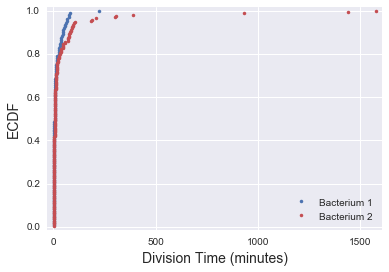

In [51]:
# Store data as Numpy arrays for speed later
bact1 = divisionTimes1
bact2 = divisionTimes2

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(bact1)
x_pest, y_pest = bebi103.ecdf(bact2)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.margins(0.02)
plt.xlabel('Division Time (minutes)')
plt.ylabel('ECDF')
plt.legend(('Bacterium 1', 'Bacterium 2'), loc='lower right');

It appears that we do have some outliers. Nevertheless, from the ECDF, the division time of bacterium2 does appear to be longer than that of bacterium1.

<div class="alert alert-info">
Longer by what degree? What is the effect size? Is it a significant difference? Without quantitation, you cannot reliably say anything about these relatively small differences.
</div> 

Let's plot individual scatter plots of the two bacteria division times now.

[0, 110, 0, 50]

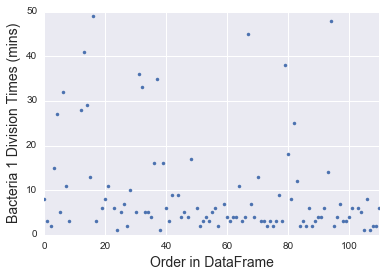

In [85]:
# Just make a scatter plot of bacteria 1
plt.plot(divisionTimes1, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('Order in DataFrame')
plt.ylabel('Bacteria 1 Division Times (mins)');
plt.axis([0,len(divisionTimes1)-1,0,50])


[0, 173, 0, 50]

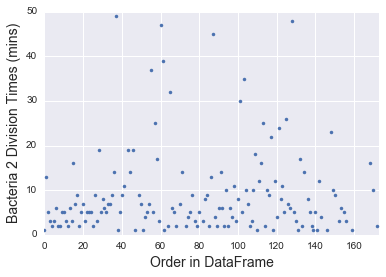

In [84]:
# Just make a scatter plot of bacteria 1
plt.plot(divisionTimes2, marker='.', linestyle='none')
plt.margins(0.02)
plt.xlabel('Order in DataFrame')
plt.ylabel('Bacteria 2 Division Times (mins)');
plt.axis([0,len(divisionTimes2)-1,0,50])

Quantatively looking at the two scatter plots with limited y ranges from [0,50] so that outliers do not rescale the plots shows that there is quite more variation in bacteria 2 division times vs. bacteria 1 division times. Although bacteria 1 may appear to have shorter division times, it is ever so slight.

<div class="alert alert-info">
Again, how can you tell? Plotting against an order here is not really meaningful. <br />
12/30
</div> 

## 9.1 Part C##

Problem 9.1(c):

In this problem, we perform model selection to determine which of the two hypotheses best explains our experimental findings. As always, we have a statistical model for the how the bacterial areas a(t) are distributed, and a mathematical model that describes how a(t) changes with t. 

Statistical Model: The deviation from the expected mean is Gaussian distributed. (e.g. Error is Gaussian.)
Statistical Assumptions: We assume uniform priors on all parameters except the standard deviation of the Gaussian, for which we pick Jeffrey's prior. 

Competing Mathematical Models: 

Model 1: Growth of a single bacterium follows an exponential curve.
Model 2: Growth of a single bacterium follows a linear curve.

Since PTMCMC takes a long time, we perform a maximum a posteriori (MAP) estimation using Powell's Method. 

We assume that Laplace's approximation holds. (The posterior is concentrated around a narrow peak.) Then, the odds ratio can be approximated as the product of the ratio of priors, Occam's factor and goodness of fit. 

For each of the two bacteria, we have the following:

From previous sections, we have the area array a(t) which contains the total bacterial area at every frame. We also have a Boolean array that keeps track of when each cell division occurs. Splitting a(t) into N division phases, we get N separate data points, each of which corresponds to a unique growth phase. For each of the N phases, we perform model selection to see which model describes the data better. We assume uniform priors on both models and we ignore Occam's Factor since both models have two parameters. Therefore, in the analysis below, we pick the model solely based on goodness of fit.

If the natural logarithm of goodness of fit is positive for most of the N data points, then we select the first model. Otherwise, we select the second model. 

In [129]:
def growth_rate(p, t, model):
    """
    Theoretical models for the growth rate.
    Model A: 
    p[0] = a_0
    p[1] = K
    p[2] = sigma
    
    Model B:
    p[0] = a_0
    p[1] = b
    p[3]
    
    """
    if model == 'A':
        #print (len(p[0] * np.exp(p[1] * t)))
        return p[0] * np.exp(p[1] * t)
    elif model == 'B':
        return p[0] + p[1] * t
    else:
        raise TypeError('Model not properly specified.')

        
def resid(p, t, rate, model):
    """
    Residuals for the growth rate model.
    """
    return rate - growth_rate(p, t, model)


def log_likelihood(p, t, rate, model):
    """
    Log likelihood for the growth rate model.
    """
    sigma = p[-1]
    
    return -np.sum(resid(p, t, rate, model)**2) / 2 / sigma**2 \
                - len(rate) / 2 * np.log(2 * np.pi * sigma**2)
    
def log_prior(p, model):
    """
    Log prior for the growth rate model.
    """
    if (p < 0).any():
        return -np.inf

    return -np.log(p[-1])


def log_posterior(p, t, rate, model):
    """
    Log posterior for the growth rate model.
    Model A: 
    p[0] = a_0
    p[1] = K
    p[2] = sigma
    
    Model B:
    p[0] = a_0
    p[1] = b
    p[3] = sigma  
    """
    lp = log_prior(p, model)
    
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(p, t, rate, model)


def neg_log_posterior(p, t, rate, model):
    return -log_posterior(p, t, rate, model)

Let's perform the analysis for bacterium 1. Then, we will repeat it for bacterium 2. 

To find the best initial estimates for the parameters, we'll use curve fitting. The idea is simple - we simply pick whichever two parameters best fit the curve for each model and we then use those parameters as our initial guess for the MAP optimization. 

In [132]:
def func_exp(t, a0, k):
    ''' 
    Model 1
    '''
    return a0 * np.exp(k*t)

def func_lin(t, a0, b):
    '''
    Model 2
    '''
    return a0 + b * t

# Initializes the relevant arrays.

log_good_fit_ratios = []
area1_1 = []

# Loops through each frame.
for i in range(len(bact1Bool)):
    area1_1.append(area1[i])
    # If the Boolean array indicates that the current frame is the last frame before division, we proceed with model selection.
    if bact1Bool[i] == True:
        # Slices the relevant subarray between two division events.
        one_bacterium_area = area1[:len(area1_1)]
        # Initializes the frames. Each frame is considered "1" unit time in this analysis.
        t = np.arange(len(one_bacterium_area))
        # Prepares the arguments for MAP optimization.
        args = (t, one_bacterium_area)
        # Optimization makes sense only if the number of frames is greater than or equal to the number of parameters. We skip
        # division series that last less than 3 frames.
        if len(t) >= 2:
            # Model A    
            popt, pcov = scipy.optimize.curve_fit(func_exp, t, one_bacterium_area)
            p0 = popt
            args_A = args + ('A',)
            res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_A, method='powell')
            popt_A = res.x
            cov_A = -np.linalg.inv(smnd.approx_hess(popt_A, log_posterior, args=args_A))
            # Model B
            popt, pcov = scipy.optimize.curve_fit(func_exp, t, one_bacterium_area)
            p0 = popt
            args_B = args + ('B',)
            res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_B, method='powell')
            popt_B = res.x
            cov_B = -np.linalg.inv(smnd.approx_hess(popt_B, log_posterior, args=args_B))
            # Calculates goodness of fit.   
            log_good_fit_ratio = log_likelihood(popt_A, *args_A) - log_likelihood(popt_B, *args_B)
            log_good_fit_ratios.append(log_good_fit_ratio)
            area1_1 = []
counts_1 = 0
counts_2 = 0
# Counts_1 and Counts_2 keep track of how many times each model was preferred over the other model. 
for i in range(len(log_good_fit_ratios)):
    if log_good_fit_ratios[i] >= 0:
        counts_1 += 1
    else:
        counts_2 += 1
    

C:\Users\andre_000\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [133]:
counts_1, counts_2

(20, 88)

We clearly see that Model 2 was a better fit than Model 1 in 88 out of 108 growth series for Bacterium 1. Now, let's repeat the same analysis for Bacterium 2: 

In [134]:
def func_exp(t, a0, k):
    ''' 
    Model 1
    '''
    return a0 * np.exp(k*t)

def func_lin(t, a0, b):
    '''
    Model 2
    '''
    return a0 + b * t

# Initializes the relevant arrays.
log_good_fit_ratios = []
area2_2 = []
# Loops through each frame.
for i in range(len(bact2Bool)):
    area2_2.append(area2[i])
    # If the Boolean array indicates that the current frame is the last frame before division, we proceed with model selection.
    if bact2Bool[i] == True:
        # Slices the relevant subarray between two division events.
        one_bacterium_area = area2[:len(area2_2)]
        # Initializes the frames. Each frame is considered "1" unit time in this analysis.
        t = np.arange(len(one_bacterium_area))
        # Prepares the arguments for MAP optimization.
        args = (t, one_bacterium_area)
        # Optimization makes sense only if the number of frames is greater than or equal to the number of parameters. We skip
        # division series that last less than 3 frames.
        if len(t) >= 2:
            # Optimization can take long to converge. Using a try/except block, we move on to the next growth series 
            # if the current series fails to converge in the desired time frame.  
            try: 
                # Model A
                popt, pcov = scipy.optimize.curve_fit(func_exp, t, one_bacterium_area)
                p0 = popt
                args_A = args + ('A',)
                res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_A, method='powell')
                popt_A = res.x
                cov_A = -np.linalg.inv(smnd.approx_hess(popt_A, log_posterior, args=args_A))
                # Model B
                popt, pcov = scipy.optimize.curve_fit(func_exp, t, one_bacterium_area)
                p0 = popt
                args_B = args + ('B',)
                res = scipy.optimize.minimize(neg_log_posterior, p0, args=args_B, method='powell')
                popt_B = res.x
                cov_B = -np.linalg.inv(smnd.approx_hess(popt_B, log_posterior, args=args_B))
                # Calculates goodness of fit.
                log_good_fit_ratio = log_likelihood(popt_A, *args_A) - log_likelihood(popt_B, *args_B)
                # Handles edge cases.
                if log_good_fit_ratio != -float('Inf') and log_good_fit_ratio != float('Inf'):
                    log_good_fit_ratios.append(log_good_fit_ratio)
                else:
                    log_good_fit_ratios.append(-999999)
            except: 
                pass
            # Resets the growth series after each iteration.
            area2_2 = []
counts_1 = 0
counts_2 = 0
# Loops through, calculating the number of series for which each is prefered over the other. 
for i in range(len(log_good_fit_ratios)):
    if log_good_fit_ratios[i] >= 0:
        counts_1 += 1
    else:
        counts_2 += 1
    

C:\Users\andre_000\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [135]:
counts_1, counts_2

(48, 112)

Just as earlier, the vast majority of time series are better modelled using Model 2. Model 1 is a better fit in only 48 out of 160 cases. 

In light of our findings, we conclude that Model 2 better explains the experimental data. Growth of an individual bacterium is more likely to be linear than exponential. 75% of the 268 growth series are better explained using a linear model as opposed to only 25% for the exponential model. 